In [31]:
import numpy as np 
import pandas as pd
import os
from gtda.time_series import PearsonDissimilarity,SlidingWindow
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape
from gtda.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split, RepeatedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report, roc_auc_score,confusion_matrix,precision_score,cohen_kappa_score,f1_score,accuracy_score
from sklearn.utils import shuffle
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
warnings.filterwarnings("ignore")
import pickle
from time import time

In [3]:
class Preprocessing:
    def __init__(self, fs, src_path, dst_path):
        self.src_path = src_path
        self.dst_path = dst_path
        self.fs = fs
        self.fname_sample, self.rating_id = ("hi.txt", 2) if dst_path.endswith("test") else ("lo.txt", 1)
        self.labels = None
        self.get_label()

    def get_label(self):
        rating_file = np.loadtxt(os.path.join(self.src_path, "ratings.txt"), delimiter=",", dtype=int)
        self.labels = rating_file

    def get_sub_label(self, sub_id):
        pos = np.argwhere(self.labels[:, 0] == sub_id)[0, 0]
        label = self.labels[pos, self.rating_id] - 1
        return int(label / 3)

    def next_sample(self):
        all_files = os.listdir(self.src_path)
        for file in all_files:
            if not file.endswith(self.fname_sample):
                continue
            sub_id = int(file[3:5])
            raw_data = np.loadtxt(os.path.join(self.src_path, file))
            yield sub_id, raw_data

In [4]:
def draw_confusion_matrix(cm, label_names, name):
    sns.set()
    mpl.rcParams['font.sans-serif'] = 'Times New Roman'
    mpl.rcParams['axes.unicode_minus'] = False
    f, ax = plt.subplots()
    sns.heatmap(cm, annot=True, ax=ax)
    try:
        ax.set(xticklabels=label_names, yticklabels=label_names)
    except Exception as e:
        print("\n")
        print(e)
        print('\n')
        label_names = ['lo', "hi"]
        ax.set(xticklabels=label_names, yticklabels=label_names)
    ax.set_title('{}'.format(name), fontsize=16, fontweight='bold')
    ax.set_xlabel('Pred Class', fontsize=14, fontweight='bold')
    ax.set_ylabel('True Class', fontsize=14, fontweight='bold')

In [5]:
def gtda(data, sliding_win=2, overlap_win=2, fs=500):
    """
    data: raw dataset
    sliding win: to represent sliding window with secod 
    overlap win: to represent overlap window with second
    """
    sliding_samples = int(sliding_win * fs)
    overlap_samples = int(overlap_win * fs)
    step = [
        SlidingWindow(size=sliding_samples,stride=overlap_samples),
        PearsonDissimilarity(absolute_value=True),
        VietorisRipsPersistence(metric='precomputed'),
        PersistenceLandscape()
    ]
    tda = make_pipeline(*step).fit_transform(data)
    return np.reshape(tda,newshape=(-1,tda.shape[1]*tda.shape[2]))

In [6]:
def pickle_obj(X, path, fname):
    with open(os.path.join(path, "{}.pkl".format(fname)), "wb") as f:
        pickle.dump(X, f)

### test 状态下的预处理器

In [7]:
cur_path = os.path.curdir
source_path = os.path.join(cur_path,"STEW_dataset")

### 特征提取

In [8]:
def gen_feature(sliding_win=1, overlap_win=0.5, preprocessor=None):
    print("current extracting feature for {} and rating id is {}".format(preprocessor.fname_sample, preprocessor.rating_id))
    for sub_id, raw_data in preprocessor.next_sample():
        fea = gtda(raw_data, sliding_win=sliding_win, overlap_win=overlap_win, fs=preprocessor.fs)
        pickle_obj(fea, path=preprocessor.dst_path, fname="S_{}".format(sub_id))
        print("extracting sub{}".format(sub_id), end=", ")

In [9]:
#sliding_win = 1
#overlap_win = 0.5

### 为test状态下提取特征

In [10]:
#dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_test")
#processor = Preprocessing(fs=128, src_path=source_path, dst_path=dest_path)

In [11]:
# 为test提取特征
#print(sliding_win, overlap_win)
#gen_feature(sliding_win=sliding_win, overlap_win=overlap_win)

### 为rest状态下提取特征

In [12]:
os.path.abspath(os.path.curdir)

'/home/data1/maliang/EEG_related/STEW'

In [13]:
#dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_rest")
#processor = Preprocessing(fs=128, src_path=source_path, dst_path=dest_path)

In [14]:
# 为rest 提取特征
#print(sliding_win, overlap_win)
##gen_feature(sliding_win=sliding_win, overlap_win=overlap_win)

In [15]:
def update_sample(sliding_win=1, overlap_win=0.5):
    # 为test提取特征
    dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_test")
    processor = Preprocessing(fs=128, src_path=source_path, dst_path=dest_path)
    print(f"滑动窗口{sliding_win}s, 重叠时间{overlap_win}s")
    gen_feature(sliding_win=sliding_win, overlap_win=overlap_win, preprocessor=processor)

    # 为rest 提取特征
    dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_rest")
    processor = Preprocessing(fs=128, src_path=source_path, dst_path=dest_path)
    print("\n")
    print(f"滑动窗口{sliding_win}s, 重叠时间{overlap_win}s")
    gen_feature(sliding_win=sliding_win, overlap_win=overlap_win, preprocessor=processor)

In [16]:
update_sample()

滑动窗口1s, 重叠时间0.5s
current extracting feature for hi.txt and rating id is 2
extracting sub34, extracting sub45, extracting sub38, extracting sub26, extracting sub10, extracting sub2, extracting sub24, extracting sub47, extracting sub36, extracting sub28, extracting sub12, extracting sub16, extracting sub8, extracting sub4, extracting sub32, extracting sub20, extracting sub43, extracting sub18, extracting sub6, extracting sub14, extracting sub41, extracting sub22, extracting sub30, extracting sub11, extracting sub3, extracting sub35, extracting sub48, extracting sub27, extracting sub39, extracting sub44, extracting sub1, extracting sub13, extracting sub46, extracting sub25, extracting sub29, extracting sub37, extracting sub33, extracting sub42, extracting sub21, extracting sub9, extracting sub17, extracting sub5, extracting sub23, extracting sub40, extracting sub31, extracting sub7, extracting sub19, extracting sub15, 

滑动窗口1s, 重叠时间0.5s
current extracting feature for lo.txt and rating id 

## 生成交叉验证的数据集    
   ### mixed_sub
   ### K-fold
   ### LOSO

#### mixed-sub

In [16]:
# objective classification 我们称为客观分类，这样的分类为二分类任务。
# 受试者有两种状态，一种休息，一种是SIMKAP test，后面这种对应的Mental workload为hi,前面那种对应的为lo
# 做这样的二分类，
# 模型的选择可以使用mixed subject, 也可以用LOSO，也可以用K-fold
# 在这里我们先用mixed subject 48个对象的数据全部使用

def gen_objective_mixed_sub():
    def get_sample(cls="test"):
        dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_{}".format(cls))
        print("cur_path is {}".format(dest_path))
        all_file = os.listdir(dest_path)
        lable = 1 if cls=="test" else 0
        sample_last = np.zeros((0,200))
        for fname in all_file:
            with open(os.path.join(dest_path, fname), "rb") as pkl_file:
                sample_sub= pickle.load(pkl_file)
                sample_last = np.concatenate((sample_last, sample_sub), axis=0)
        return sample_last
    simkap_test_sample = get_sample("test")
    label_hi = np.zeros((len(simkap_test_sample), 1)) + 1
    rest_sample = get_sample("rest")
    label_lo = np.zeros((len(rest_sample), 1))
    sample = np.concatenate((simkap_test_sample, rest_sample), axis=0)
    label = np.concatenate((label_hi, label_lo), axis=0)
    return sample, label

In [17]:
def objective_mixed_sub(classifier, sample, label):
    x_train, x_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, shuffle=True)
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
    draw_confusion_matrix(cf_matrix, ["low", "high"], "objective binary task")
    print(classification_report(y_test,y_pred,digits=4))

In [15]:
sample, label = gen_objective_mixed_sub()

cur_path is ./fea_pkl_dir/pkl_test
cur_path is ./fea_pkl_dir/pkl_rest


In [40]:
sample.shape, label.shape

((21504, 200), (21504, 1))

              precision    recall  f1-score   support

         0.0     0.9729    0.9440    0.9583      1447
         1.0     0.9720    0.9867    0.9793      2854

    accuracy                         0.9723      4301
   macro avg     0.9725    0.9654    0.9688      4301
weighted avg     0.9723    0.9723    0.9722      4301



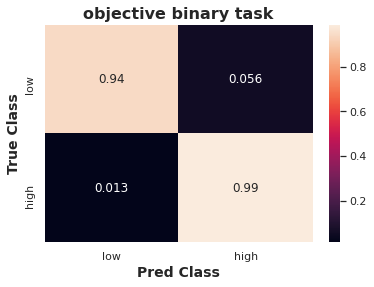

In [41]:
clf = RandomForestClassifier()
objective_mixed_sub(clf, sample, label)

In [43]:
len(np.arange(30).reshape((6,5)))

6

In [44]:
np.zeros((0,200))

array([], shape=(0, 200), dtype=float64)

#### intra-subject

In [18]:
def Kfold_validation(classifier,sample_pwi, label_pwi,groups, sw=1,task='binary', sub="666", path="mixed_sub_rs", pw_level=0, show_cm=1, repeats=10):
    results = np.zeros((repeats*5, 7))
    gkf = GroupKFold(n_splits=5)
    #kf = RepeatedKFold(n_splits=5, n_repeats=repeats, random_state=666)
    for idx, train_test_index in enumerate(gkf.split(sample_pwi, label_pwi, groups)):
        x_train, y_train, x_test, y_test = sample_pwi[train_test_index[0]], label_pwi[train_test_index[0]], sample_pwi[train_test_index[1]], label_pwi[train_test_index[1]]
        classifier.fit(x_train, y_train)
        y_pred = classifier.predict(x_test)
        y_prob = classifier.predict_proba(x_test)[:,1]
        if show_cm:
            cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
            lables_name = ["low", "high"] if task=='binary' else ["lo","mi", "hi"]
            title_name = "objective binary task" if task=="binary" else "subjective tenary task"
            draw_confusion_matrix(cf_matrix, label_names=lables_name, name=title_name)
            #draw_confusion_matrix(cf_matrix, ["low", "high"], "sub{} pw{} of {} task".format(sub, pw_level, path.split("_")[0]))
            show_cm = 0
        cohen_kappa_s = cohen_kappa_score(y_test, y_pred)
        roc_score = roc_auc_score(y_test, y_prob)
        acc = accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)
        micro_precision_s = precision_score(y_test, y_pred, average="micro")
        macro_precision_s = precision_score(y_test, y_pred, average="macro")
        weight_precision_s = precision_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="micro")
        results[idx, :] = roc_score, cohen_kappa_s, micro_precision_s, macro_precision_s, weight_precision_s, f1, acc
    np.savetxt(f"./all_result/{path}/{task}/{str(sw)}/S{sub}_rs.csv", results, delimiter=",", fmt="%10.5f")  

In [32]:
def intra_subject(sw):
    for idx in range(1, 49):
        clf = RF()
        #clf = LR()
        #clf = MLP()
        #clf = KNN()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        SIMKAP_dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_test")
        REST_dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_rest")
        # 拿到当前对象的样本
        test_sample_path = [SIMKAP_dest_path, REST_dest_path]
        sample_last = np.zeros((0,200))
        out_fname = "S_{}.pkl".format(idx)
        for path in test_sample_path:
            with open(os.path.join(path, out_fname), "rb") as pkl_file:
                test_sample = pickle.load(pkl_file) 
                sample_last = np.concatenate((sample_last, test_sample), axis=0)

        samples = copy.deepcopy(sample_last)
        y_test = np.zeros((len(test_sample), 1))
        labels = np.concatenate(((y_test + 1), y_test), axis=0)
        # 此处是为了将数据分组，避免随机K-FOLD时，导致一部分数据在训练集中泄露
        n_samples = test_sample.shape[0]
        groups = np.zeros(n_samples)
        groups[:int(n_samples/5)] = 1
        groups[int(n_samples/5):int(n_samples*2/5)] = 2
        groups[int(n_samples*2/5):int(n_samples*3/5)] = 3
        groups[int(n_samples*3/5):int(n_samples*4/5)] = 4
        groups[int(n_samples*4/5):] = 5 
        groups = np.tile(groups, len(test_sample_path))
        print("subject{}数据集大小 sample: {}, label: {}".format(idx, samples.shape, labels.shape))
        start = time()
        Kfold_validation(clf, samples, labels, groups, sw=sw, task="binary", sub=idx, path="RF/intra_subject", pw_level=0, show_cm=0, repeats=1)
        end = time()
        print(f"{idx}: {round((end-start), 4)}s")

In [33]:
#update_sample(sliding_win=1, overlap_win=0.5)
for s in range(1, 5):
    update_sample(sliding_win=s, overlap_win=s/2)
    intra_subject(sw=s)

滑动窗口1s, 重叠时间0.5s
current extracting feature for hi.txt and rating id is 2
extracting sub29, extracting sub42, extracting sub23, extracting sub6, extracting sub40, extracting sub43, extracting sub38, extracting sub10, extracting sub27, extracting sub21, extracting sub34, extracting sub41, extracting sub13, extracting sub7, extracting sub47, extracting sub39, extracting sub36, extracting sub33, extracting sub32, extracting sub8, extracting sub35, extracting sub30, extracting sub14, extracting sub5, extracting sub9, extracting sub24, extracting sub4, extracting sub17, extracting sub25, extracting sub3, extracting sub44, extracting sub18, extracting sub31, extracting sub26, extracting sub12, extracting sub2, extracting sub16, extracting sub20, extracting sub37, extracting sub19, extracting sub28, extracting sub46, extracting sub15, extracting sub1, extracting sub48, extracting sub45, extracting sub22, extracting sub11, 

滑动窗口1s, 重叠时间0.5s
current extracting feature for lo.txt and rating id 

#### LOSO

In [74]:
import copy

In [21]:
# objective binary classification， 
# 另一种模型选择的方法是使用LOSO，选一个人的作为测试集，其它人的作为训练集, 
# 这种方式，48个对象的数据均可以使用，因此，最终可以得到48组结果
def gen_objectiv_LOSO(out_sub_id=1):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    SIMKAP_dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_test")
    REST_dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_rest")
    # 拿到测试集
    test_sample_path = [SIMKAP_dest_path, REST_dest_path]
    sample_last = np.zeros((0,200))
    out_fname = "S_{}.pkl".format(out_sub_id)
    for path in test_sample_path:
        with open(os.path.join(path, out_fname), "rb") as pkl_file:
            test_sample = pickle.load(pkl_file) 
            sample_last = np.concatenate((sample_last, test_sample), axis=0)

    x_test = copy.deepcopy(sample_last)
    y_test = np.zeros((len(test_sample), 1))
    y_test = np.concatenate(((y_test + 1), y_test), axis=0)
    
    print("得到测试集 leave sub {} out".format(out_fname))
    print("测试集大小 sample: {}, label: {}".format(x_test.shape, y_test.shape))
    #return
    # 拿到训练集
    def get_sample(cls="test"):
        dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_{}".format(cls))
        all_file = os.listdir(dest_path)
        lable = 1 if cls=="test" else 0
        all_file.remove(out_fname)
        sample_last = np.zeros((0, 200))
        for fname in all_file:
            with open(os.path.join(dest_path, fname), "rb") as pkl_file:
                sample_sub= pickle.load(pkl_file)
                sample_last = np.concatenate((sample_last, sample_sub), axis=0)
        return sample_last
    simkap_test_sample = get_sample("test")
    label_hi = np.zeros((len(simkap_test_sample), 1)) + 1
    rest_sample = get_sample("rest")
    label_lo = np.zeros((len(rest_sample), 1))
    sample = np.concatenate((simkap_test_sample, rest_sample), axis=0)
    label = np.concatenate((label_hi, label_lo), axis=0)
    print("得到训练集")
    print("训练集大小 sample: {}, label: {}".format(sample.shape, label.shape))
    return sample, label, x_test, y_test


In [76]:
x_train, y_train, x_test, y_test = gen_objectiv_LOSO()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
得到测试集 leave sub S_1.pkl out
测试集大小 sample: (148, 200), label: (148, 1)
得到训练集
训练集大小 sample: (6956, 200), label: (6956, 1)


In [22]:
# 开始LOSO训练，
# 每一个对象都要被OUT一次，所以最终会有48个结果
from sklearn.utils import shuffle
def objective_LOSO(sw=1):
    results = np.zeros((48, 6), dtype=float)
    for idx in range(1, 49):
        # classifier = RandomForestClassifier()
        #clf = LR()
        #clf = MLP()
        clf = KNN()
        x_train, y_train, x_test, y_test = gen_objectiv_LOSO(out_sub_id=idx)
        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
        draw_confusion_matrix(cf_matrix, ["low", "high"], "objective binary task")
        #print(classification_report(y_test,y_pred,digits=4))
        
        y_prob = clf.predict_proba(x_test)[:,1]

        cohen_kappa_s = cohen_kappa_score(y_test, y_pred)
        roc_score = roc_auc_score(y_test, y_prob)
        micro_precision_s = precision_score(y_test, y_pred, average="micro")
        macro_precision_s = precision_score(y_test, y_pred, average="macro")
        weight_precision_s = precision_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="micro")
        results[idx-1, :] = roc_score, cohen_kappa_s, micro_precision_s, macro_precision_s, weight_precision_s,f1
    np.savetxt("./all_result/{}/{}/{}/out.csv".format("LOSO", "binary", str(sw)), results, delimiter=",", fmt="%10.5f")

滑动窗口1s, 重叠时间0.5s
current extracting feature for hi.txt and rating id is 2
extracting sub34, extracting sub45, extracting sub38, extracting sub26, extracting sub10, extracting sub2, extracting sub24, extracting sub47, extracting sub36, extracting sub28, extracting sub12, extracting sub16, extracting sub8, extracting sub4, extracting sub32, extracting sub20, extracting sub43, extracting sub18, extracting sub6, extracting sub14, extracting sub41, extracting sub22, extracting sub30, extracting sub11, extracting sub3, extracting sub35, extracting sub48, extracting sub27, extracting sub39, extracting sub44, extracting sub1, extracting sub13, extracting sub46, extracting sub25, extracting sub29, extracting sub37, extracting sub33, extracting sub42, extracting sub21, extracting sub9, extracting sub17, extracting sub5, extracting sub23, extracting sub40, extracting sub31, extracting sub7, extracting sub19, extracting sub15, 

滑动窗口1s, 重叠时间0.5s
current extracting feature for lo.txt and rating id 

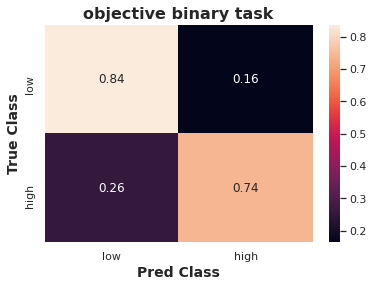

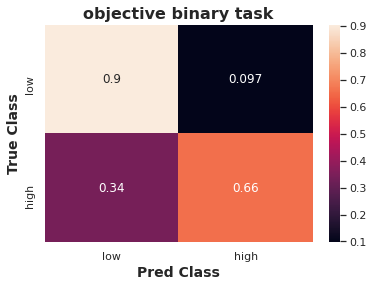

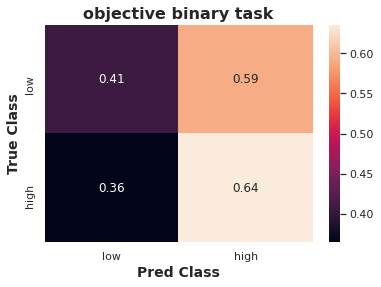

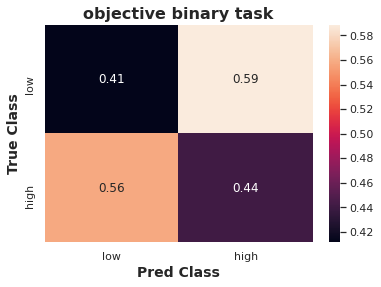

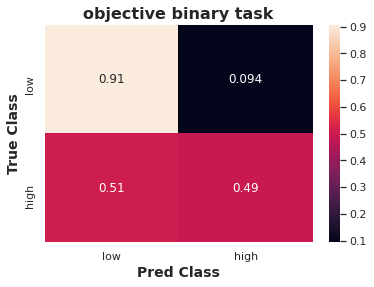

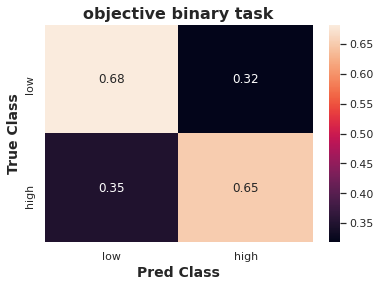

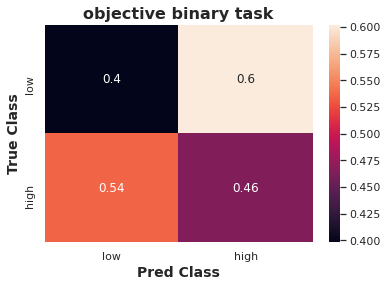

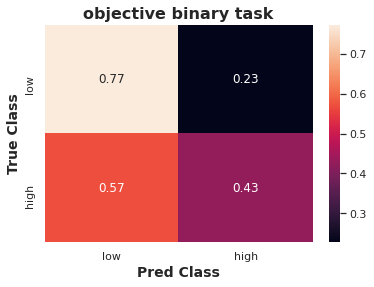

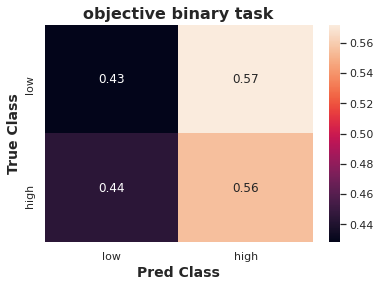

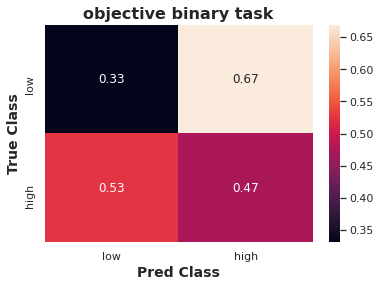

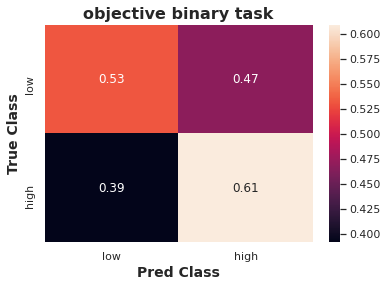

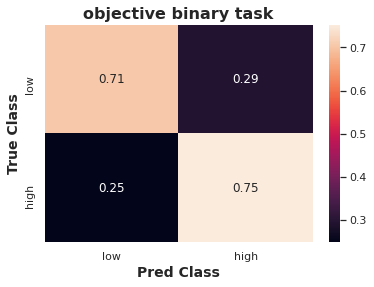

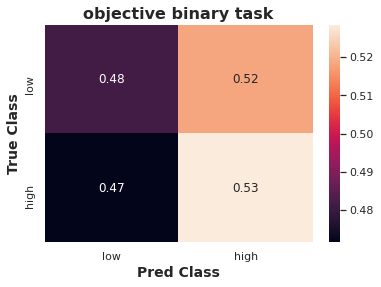

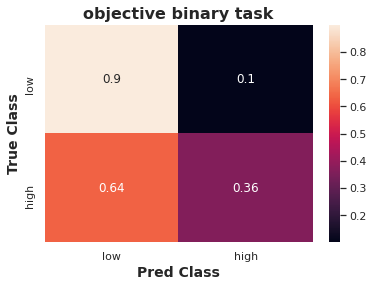

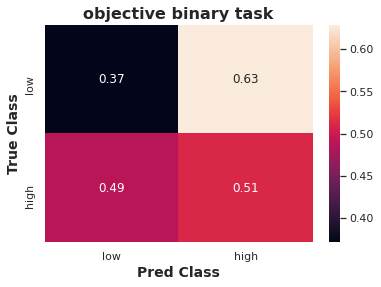

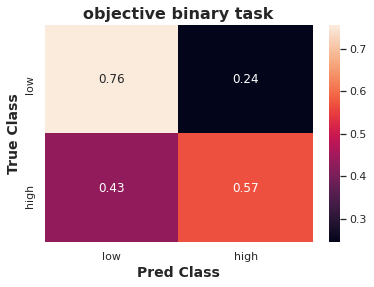

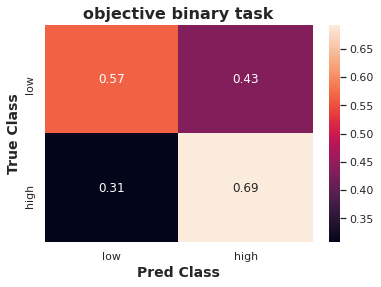

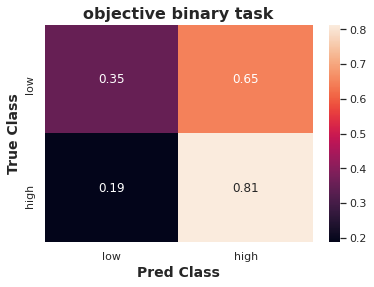

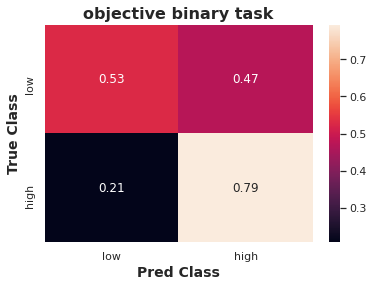

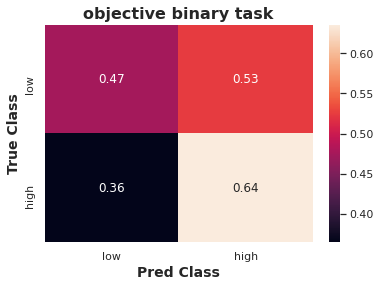

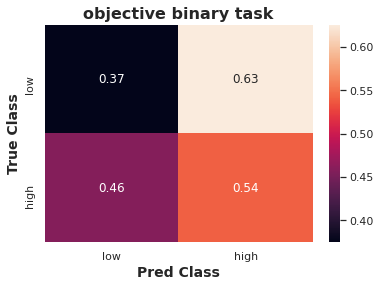

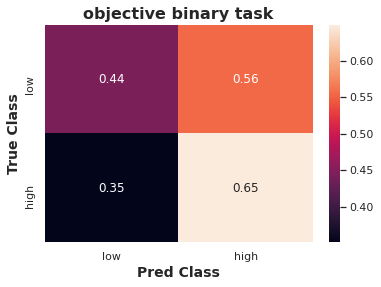

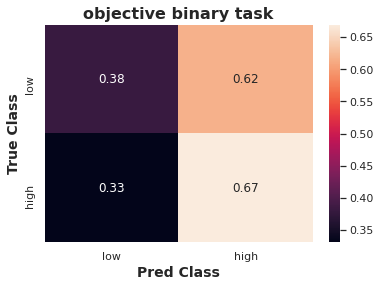

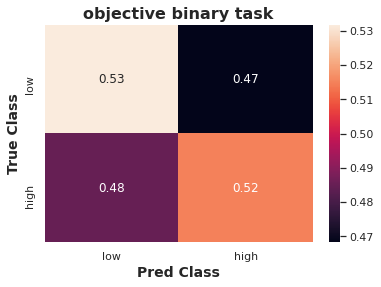

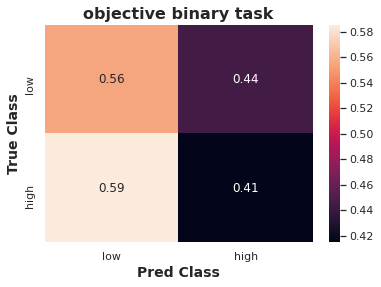

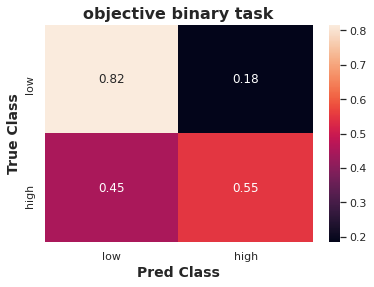

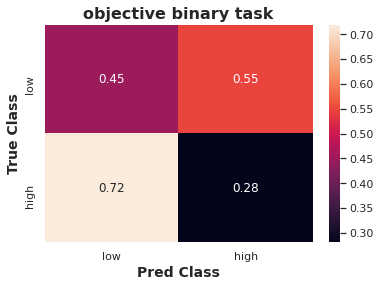

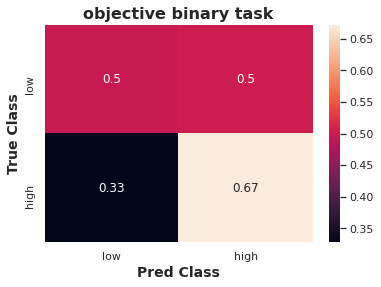

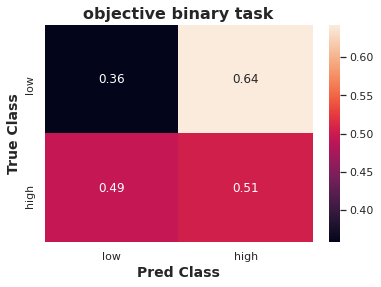

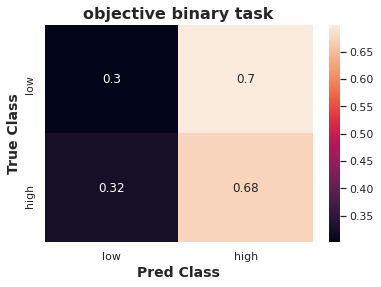

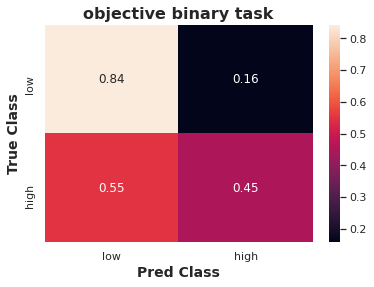

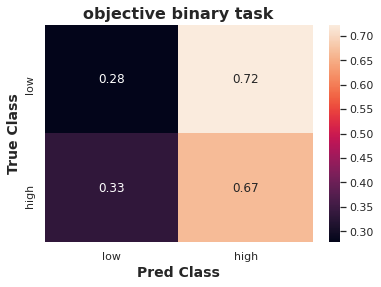

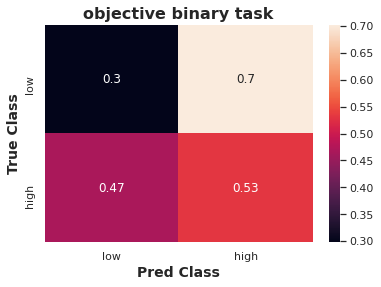

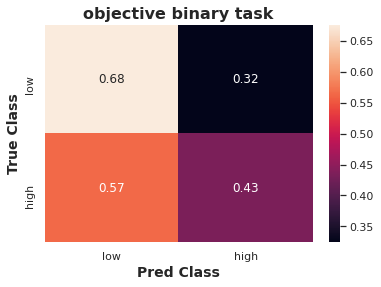

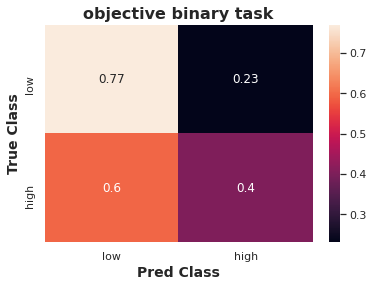

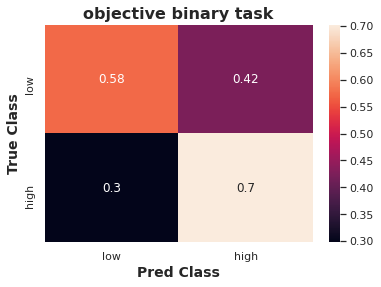

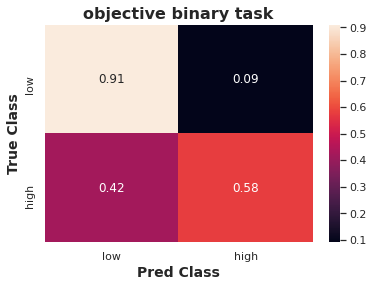

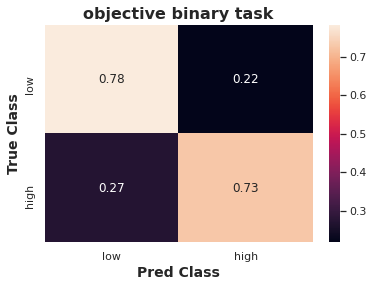

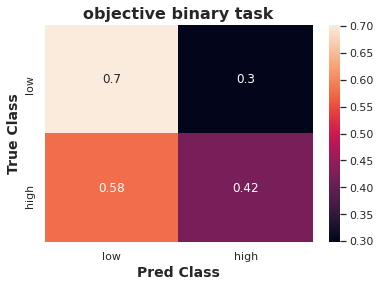

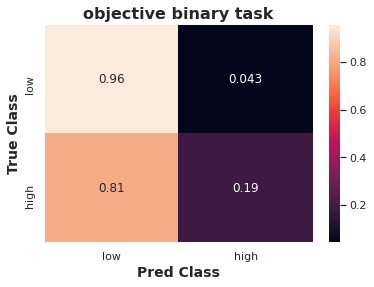

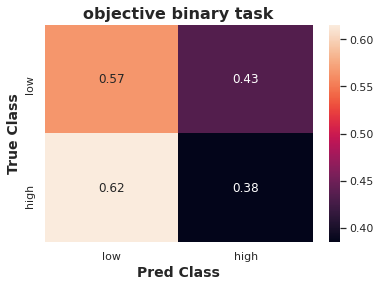

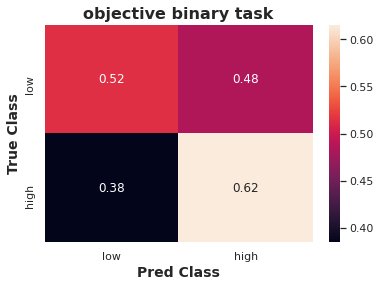

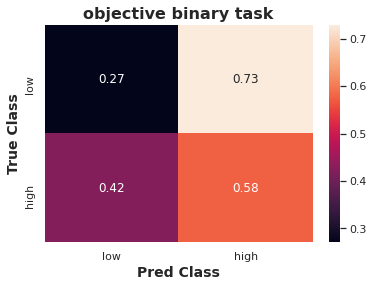

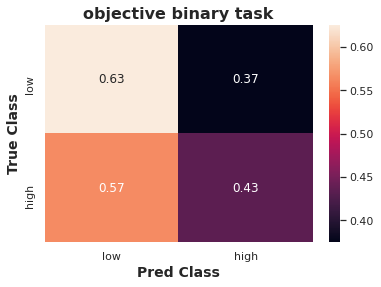

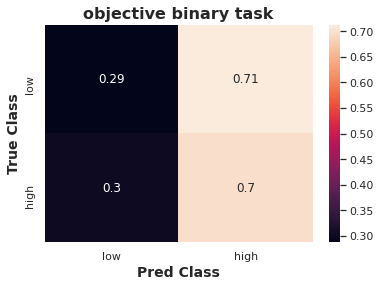

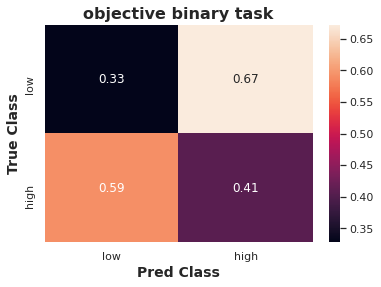

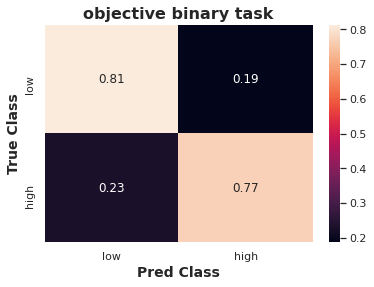

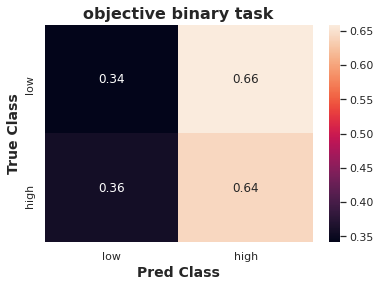

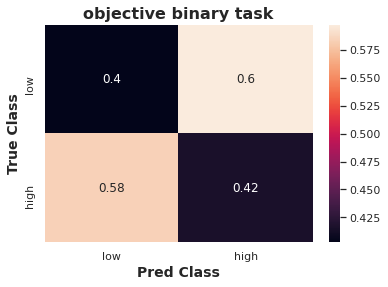

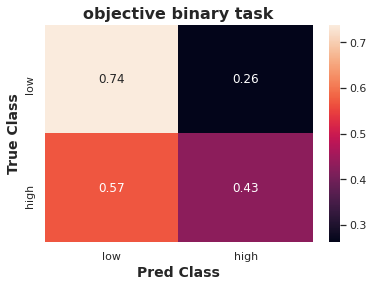

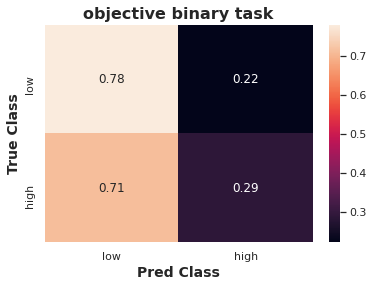

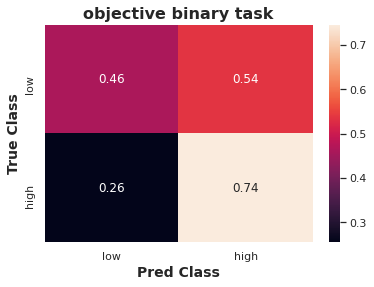

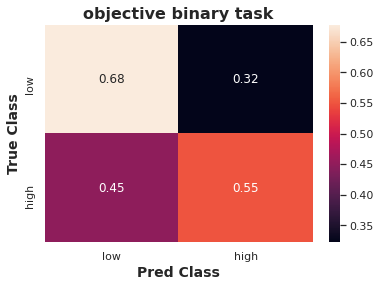

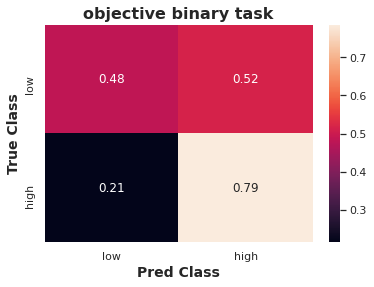

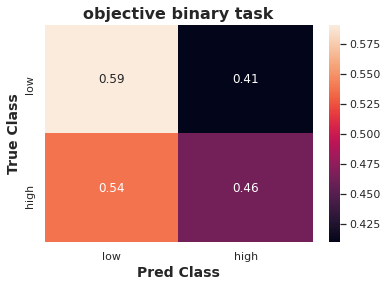

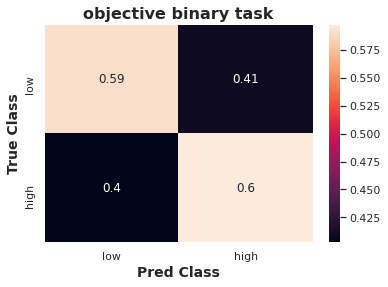

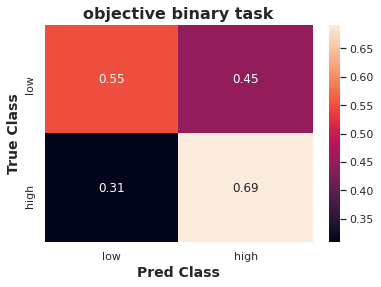

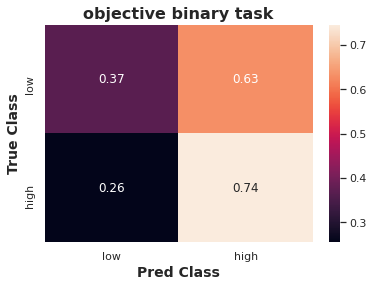

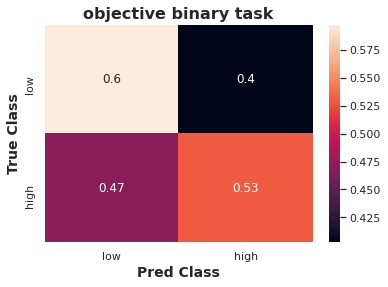

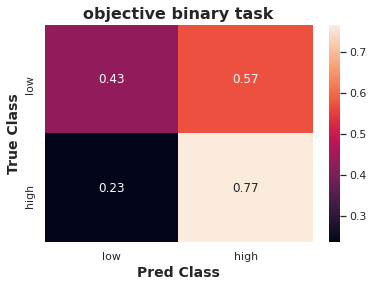

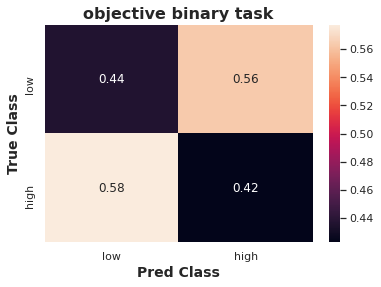

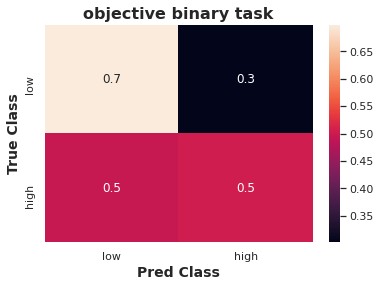

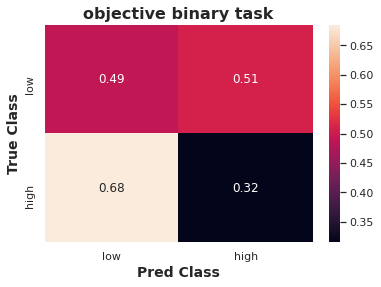

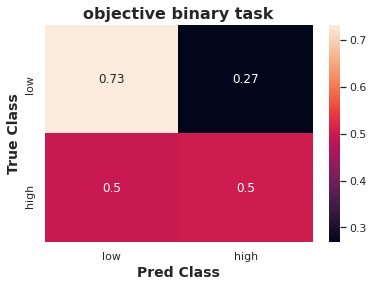

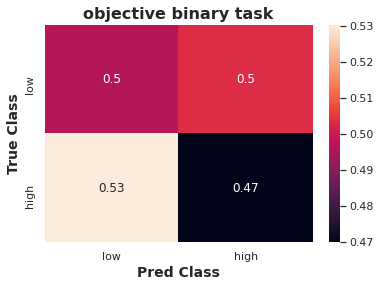

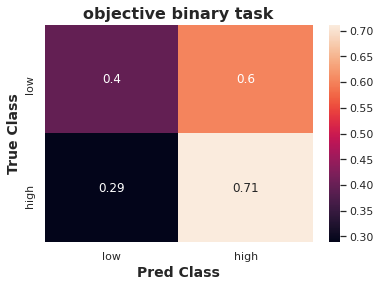

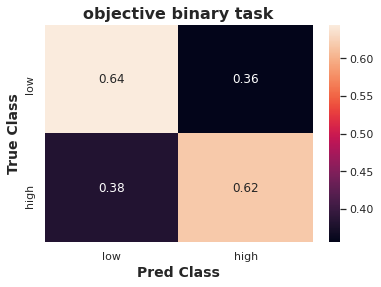

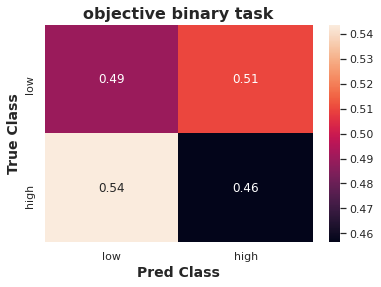

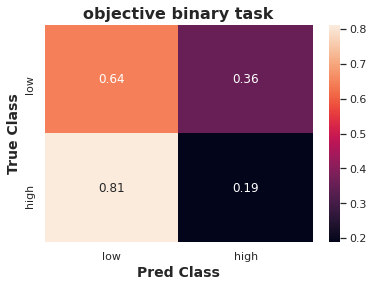

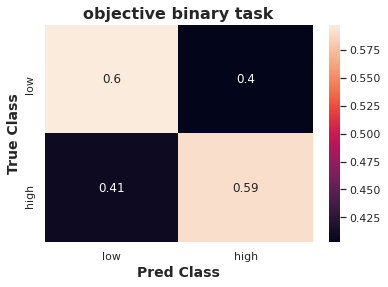

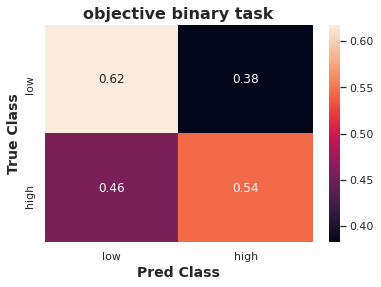

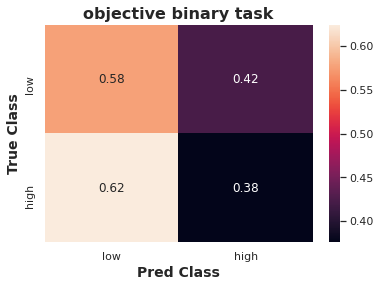

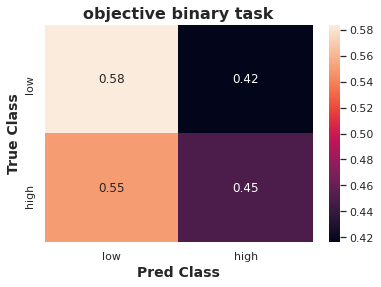

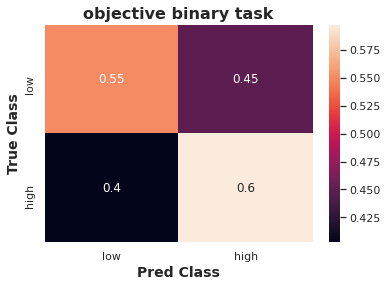

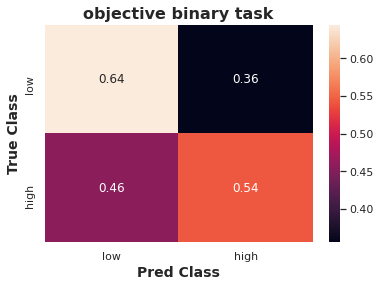

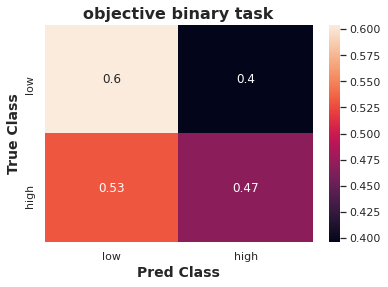

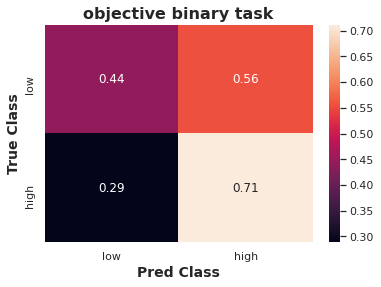

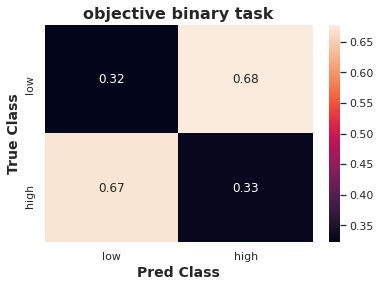

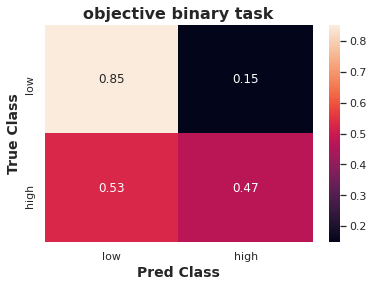

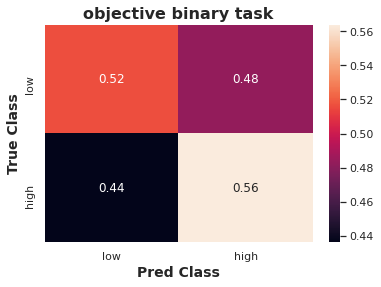

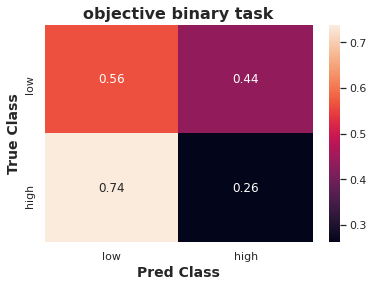

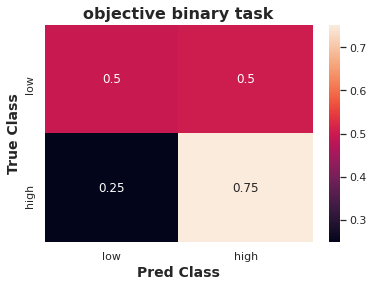

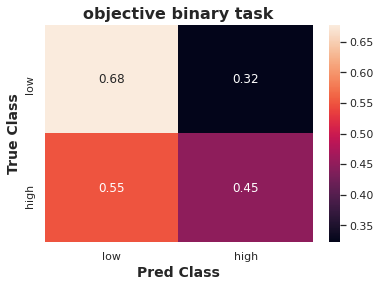

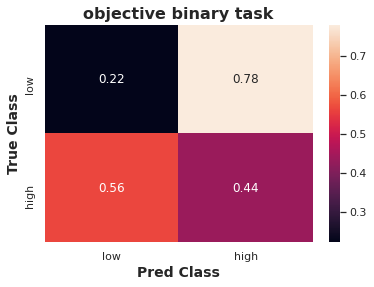

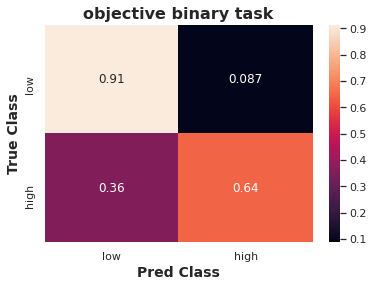

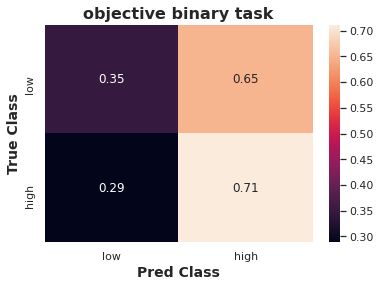

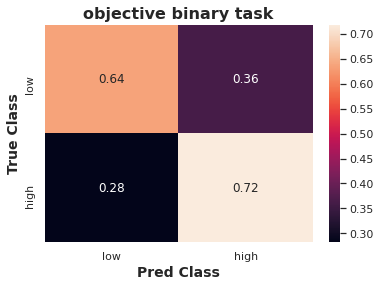

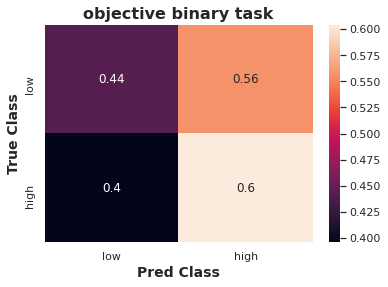

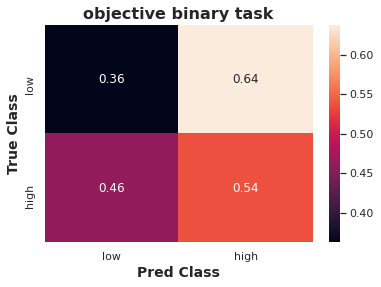

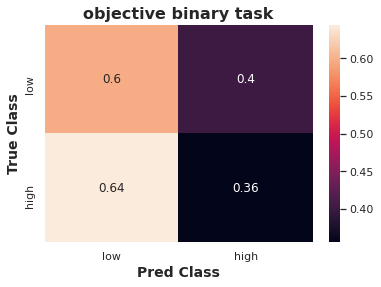

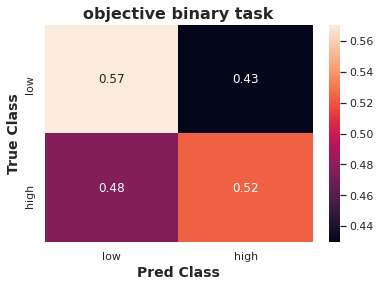

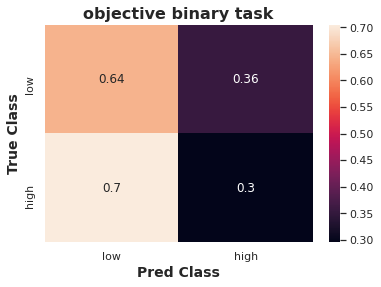

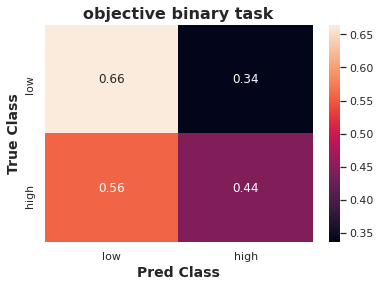

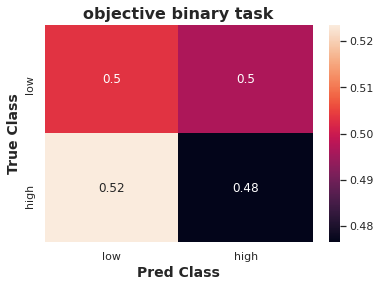

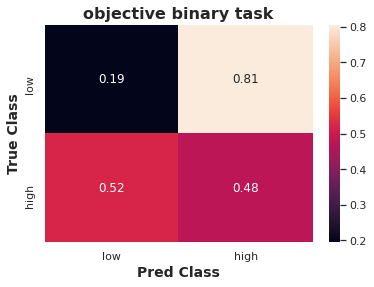

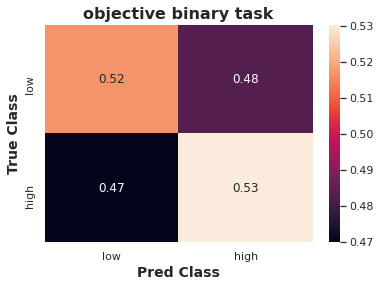

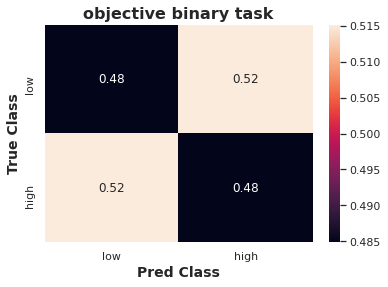

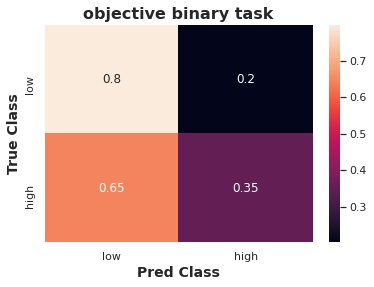

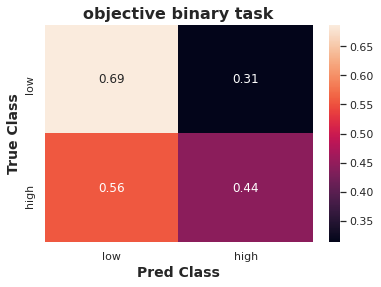

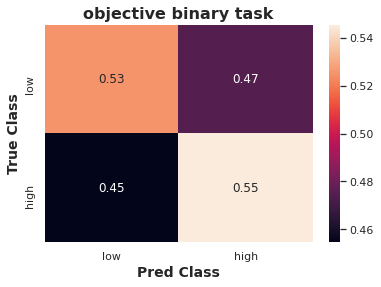

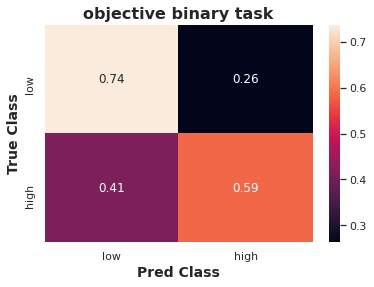

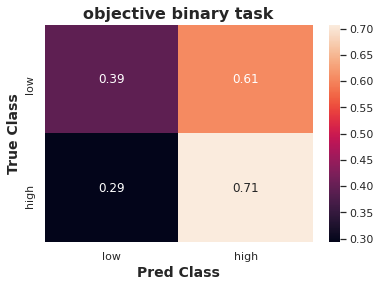

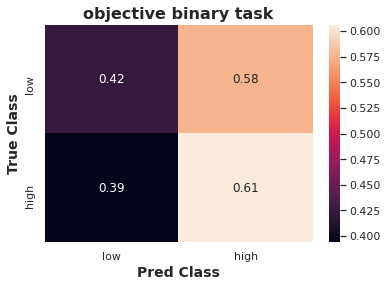

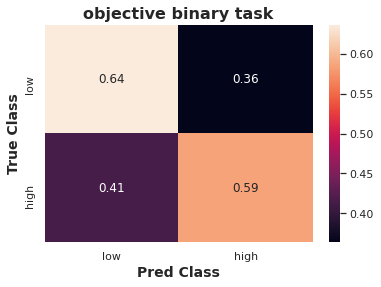

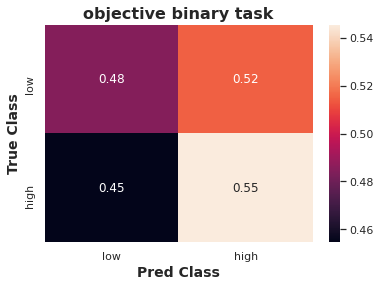

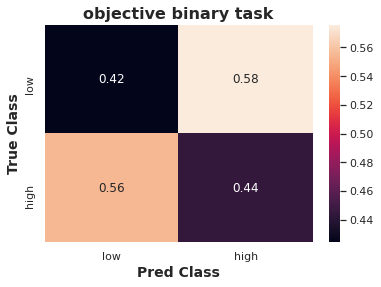

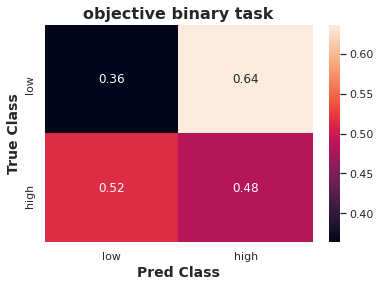

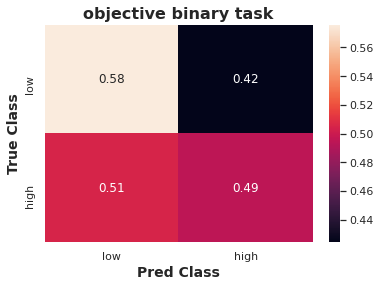

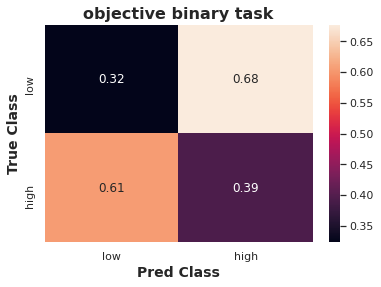

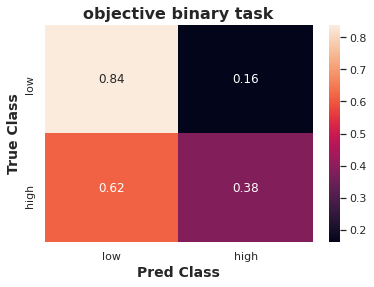

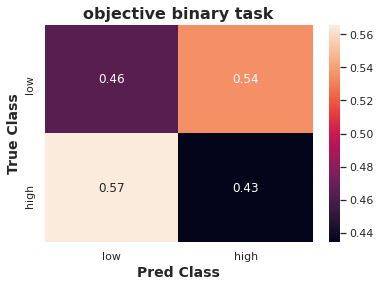

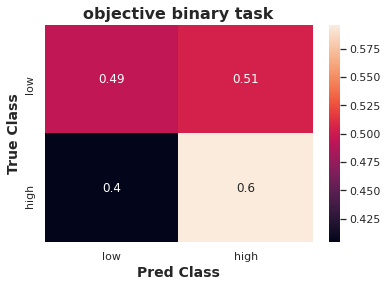

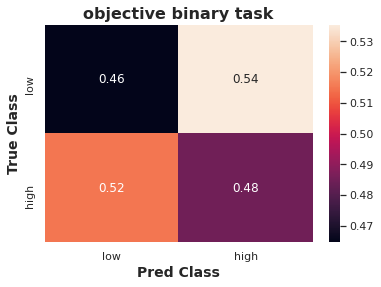

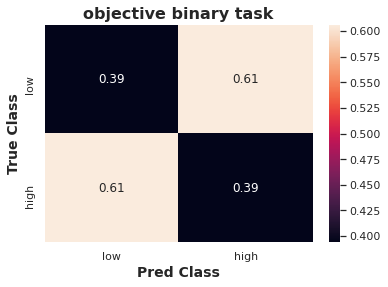

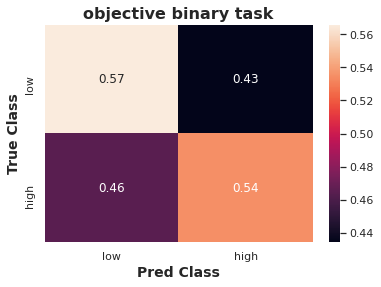

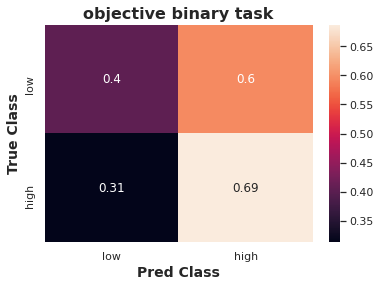

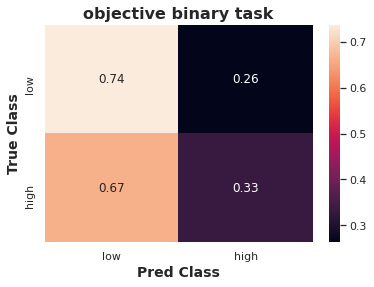

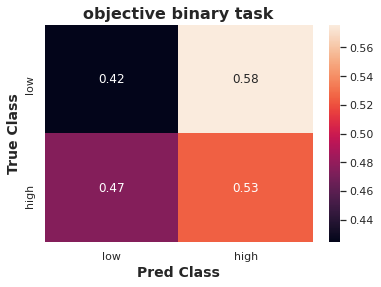

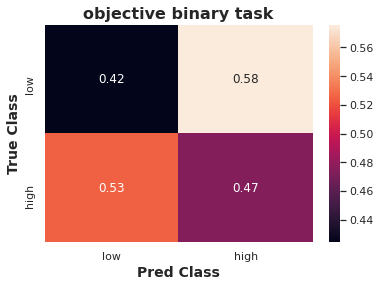

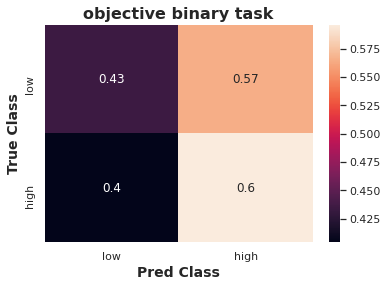

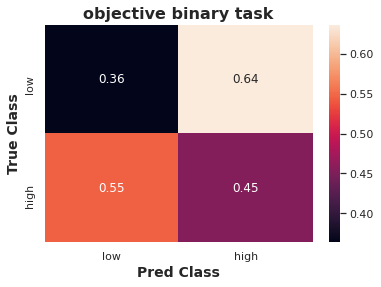

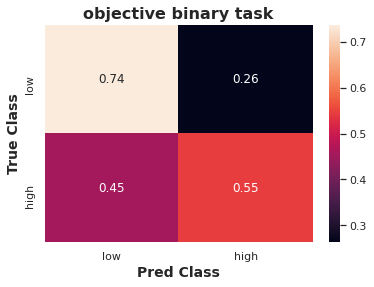

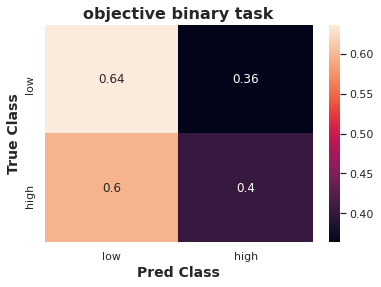

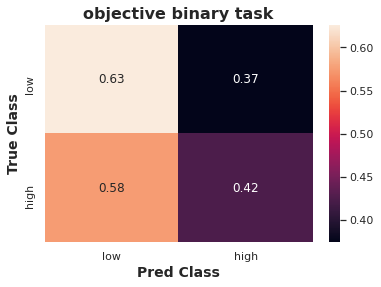

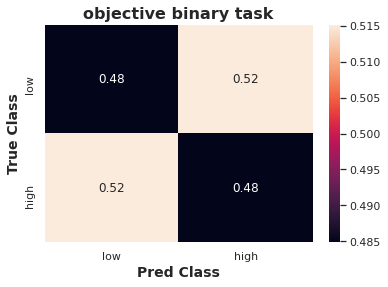

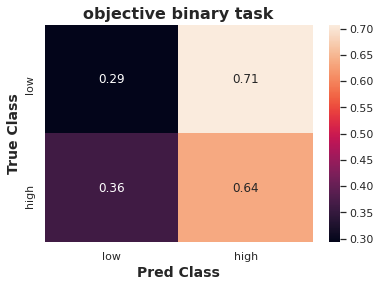

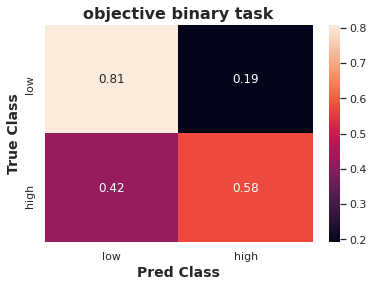

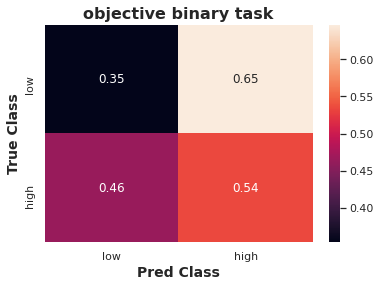

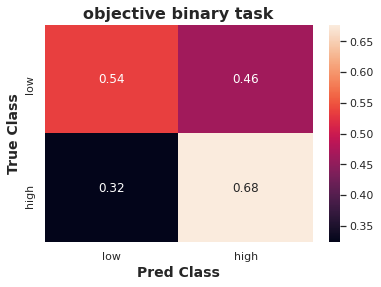

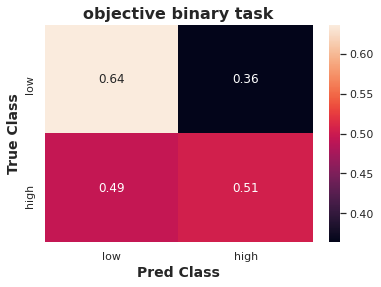

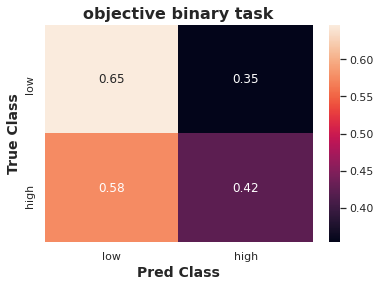

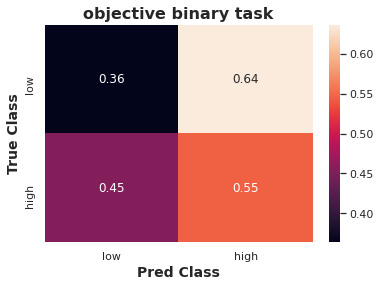

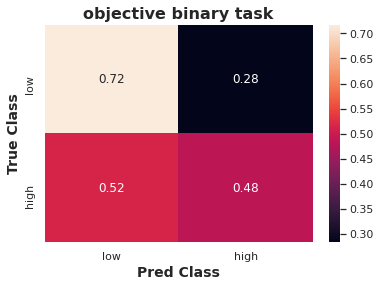

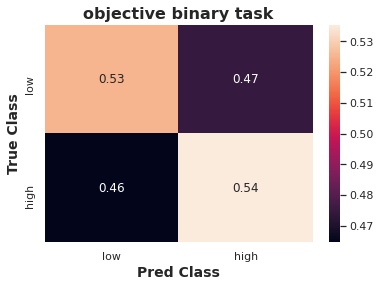

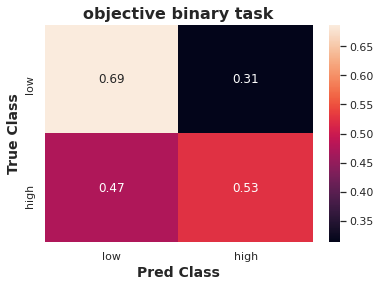

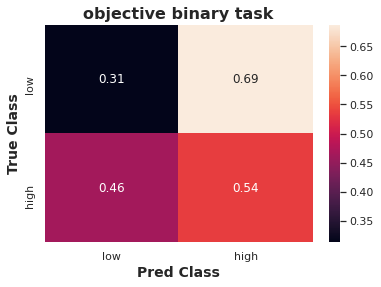

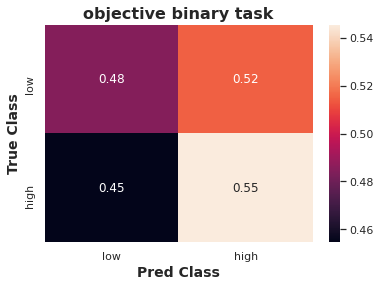

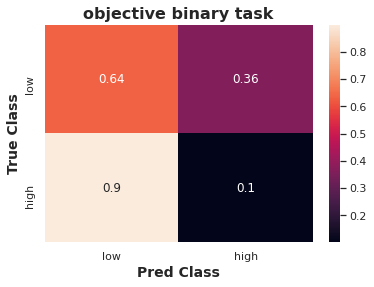

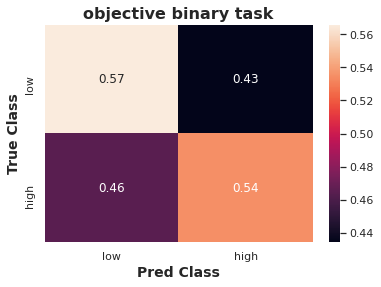

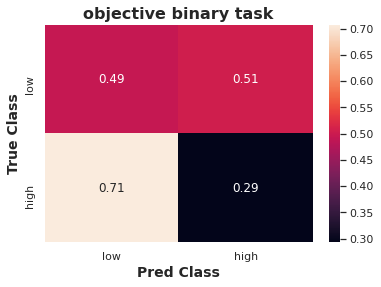

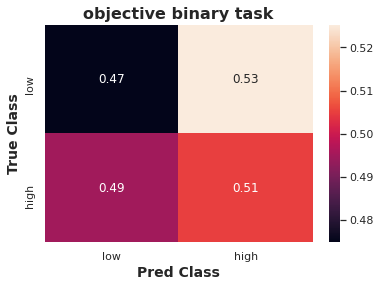

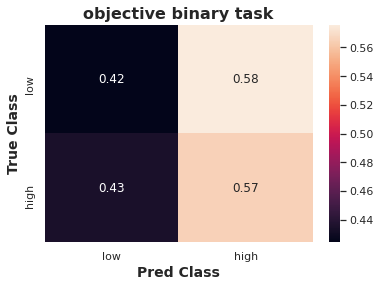

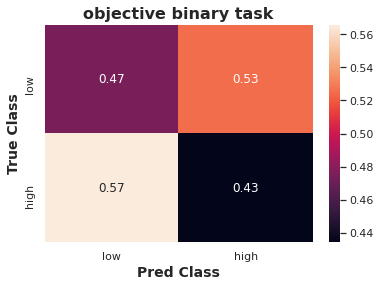

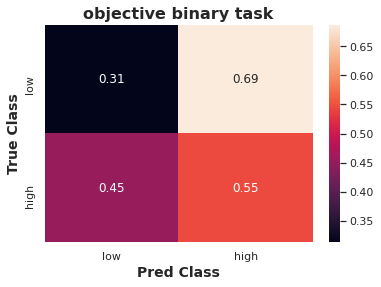

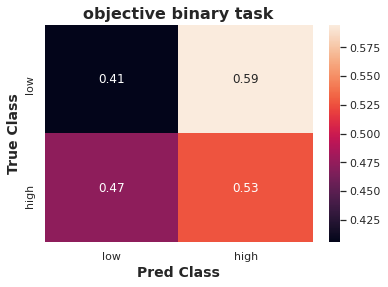

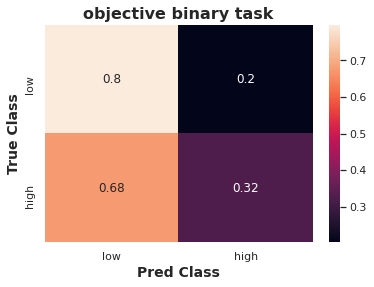

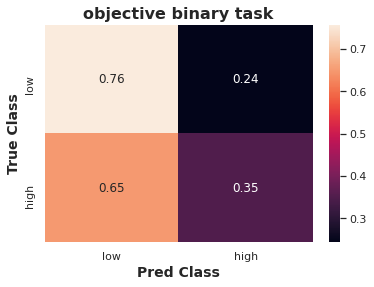

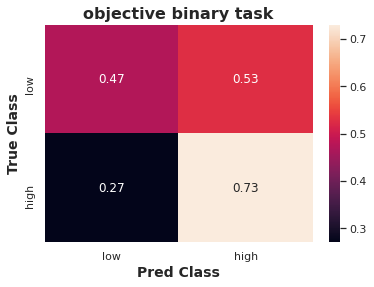

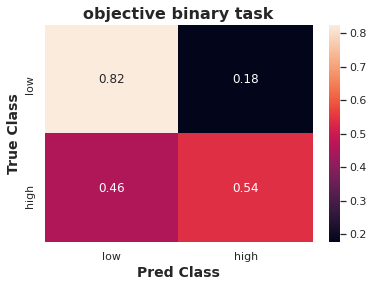

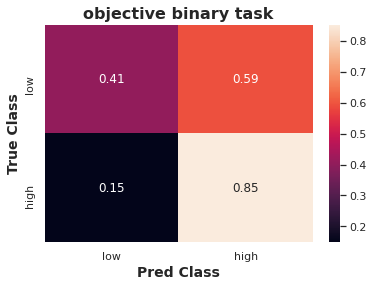

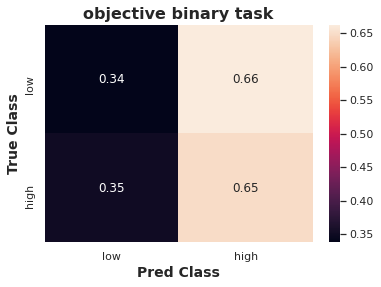

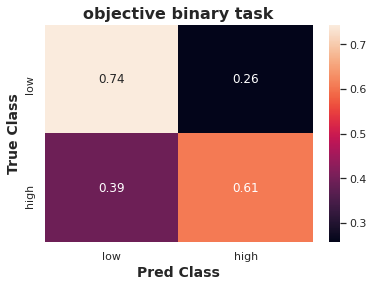

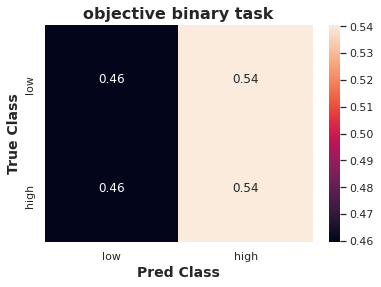

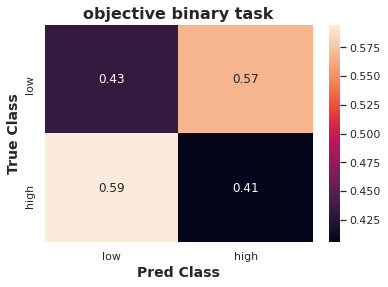

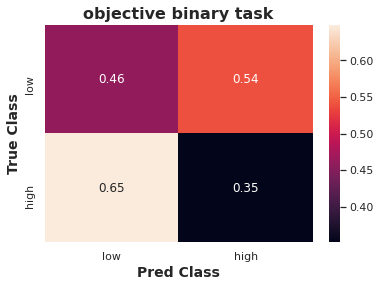

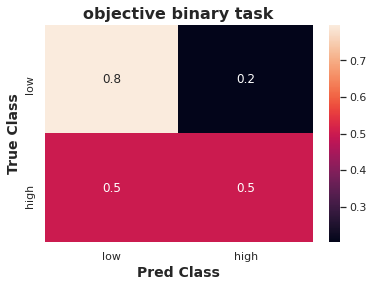

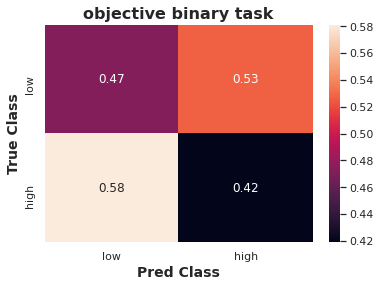

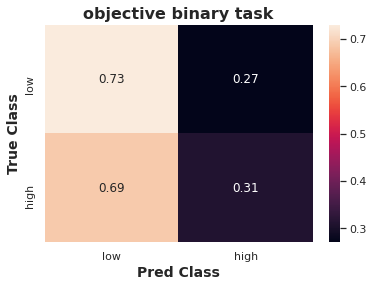

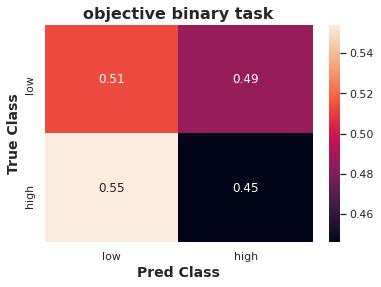

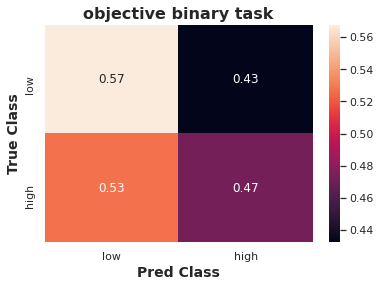

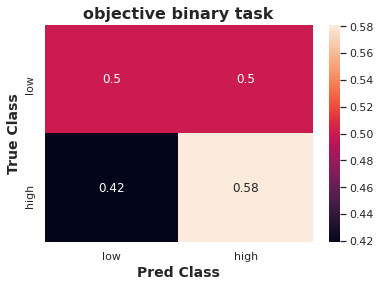

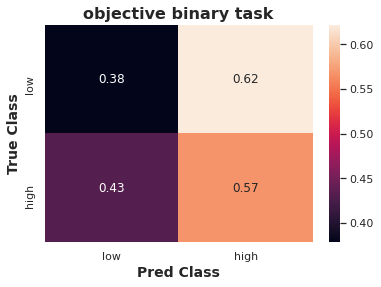

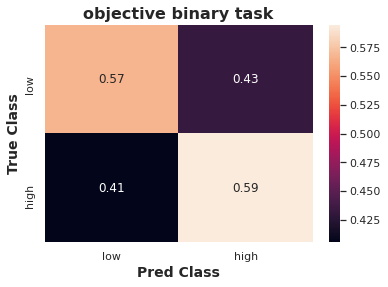

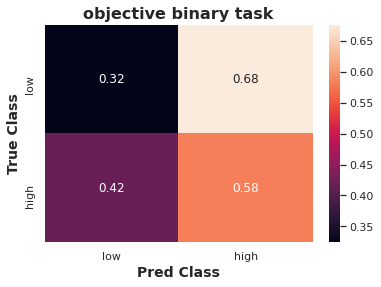

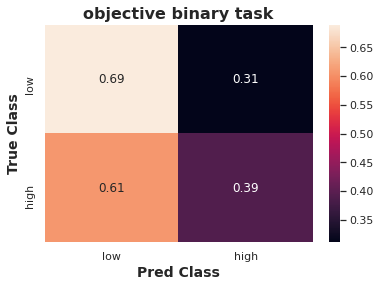

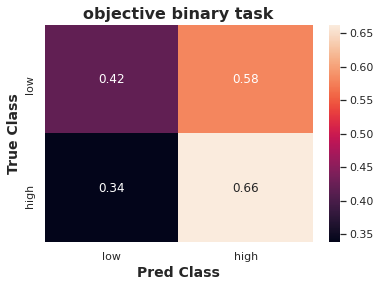

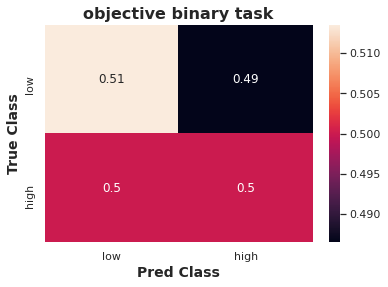

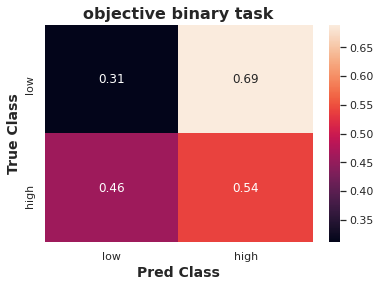

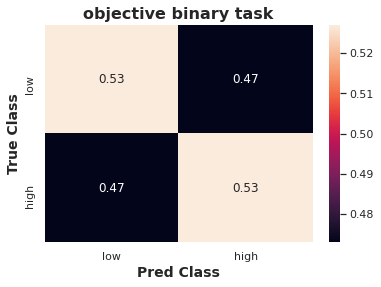

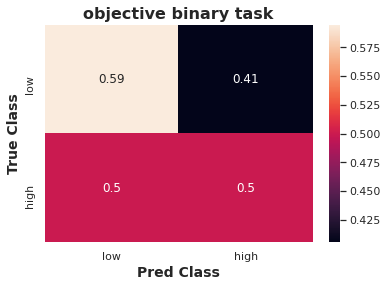

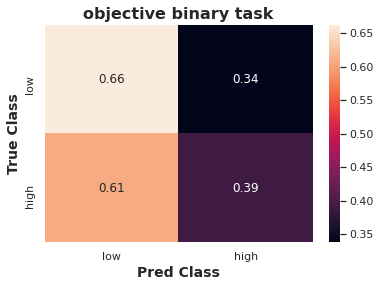

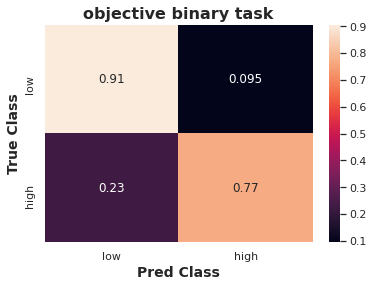

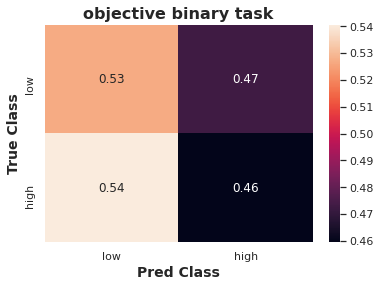

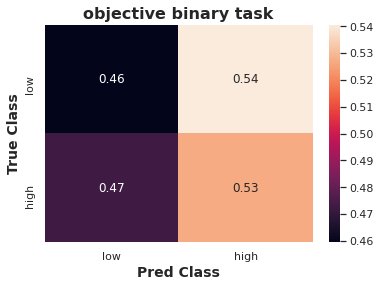

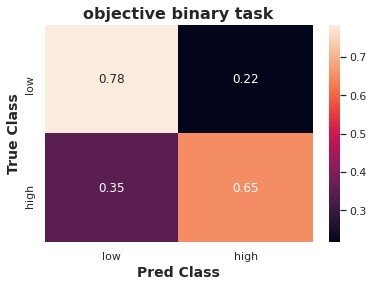

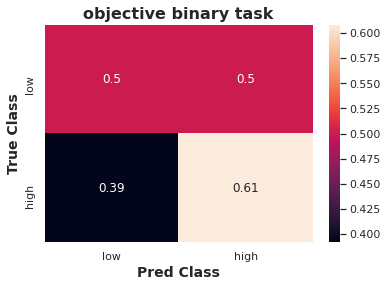

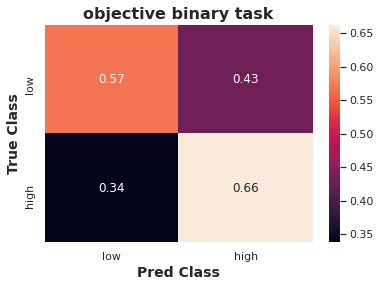

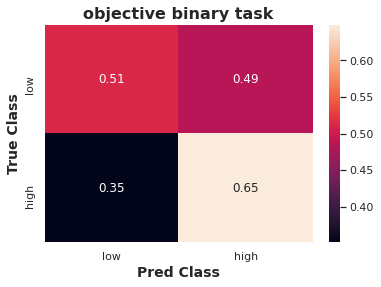

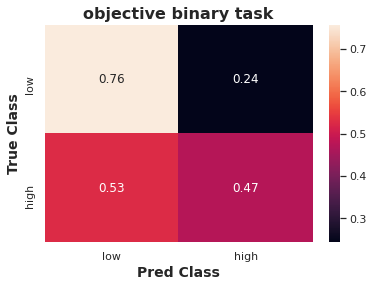

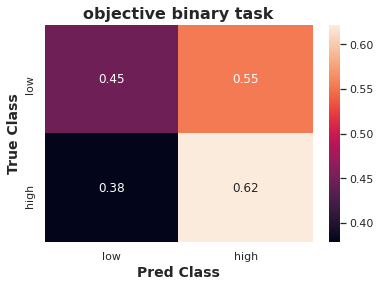

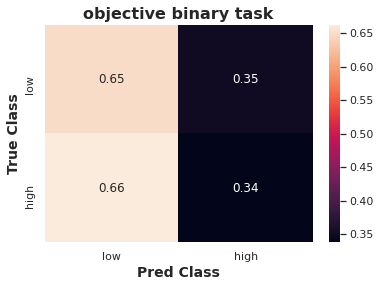

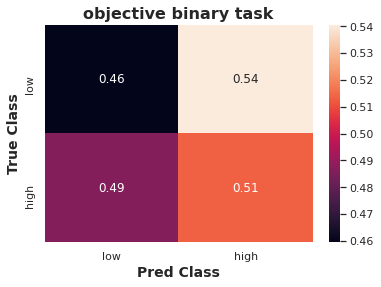

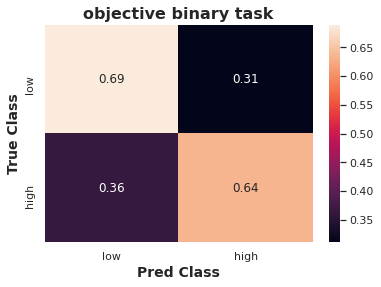

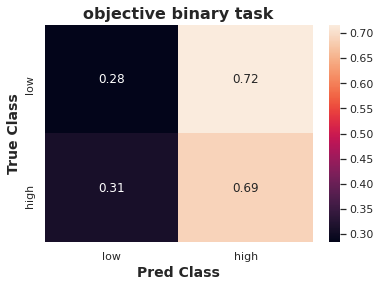

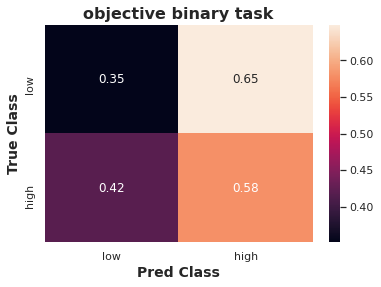

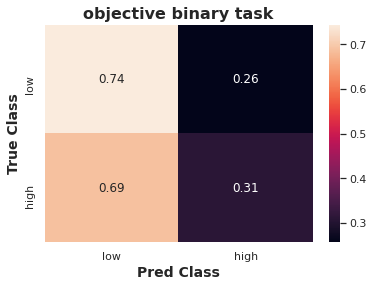

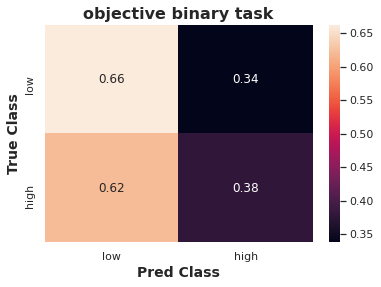

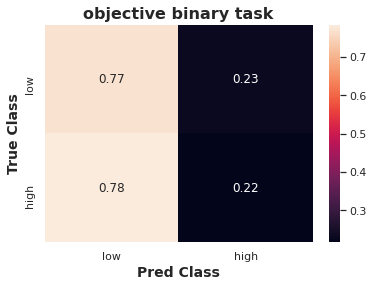

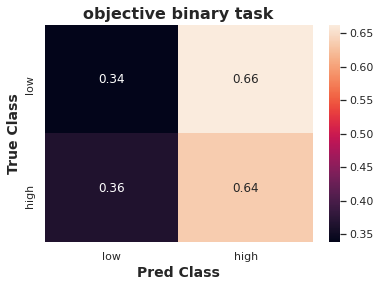

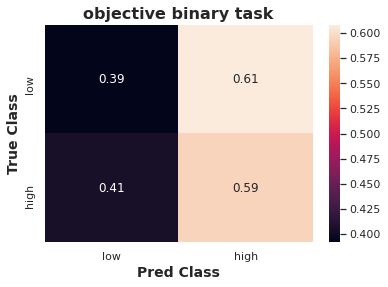

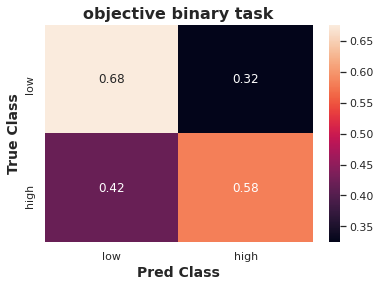

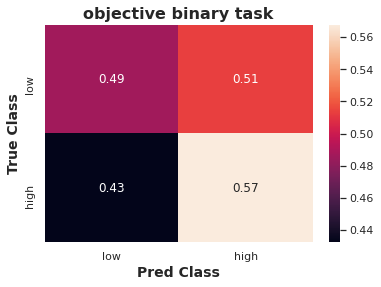

In [79]:
for sw in range(1, 5):
    update_sample(sliding_win=sw, overlap_win=sw/2)
    objective_LOSO(sw)

# subjective tenary classification
### 这里分类方式，将不在以rest 和test 为分类基准
### 而是以受试者的主观评价为分类标准，
### 受试者在rating.txt表中分别对rest 和test 两种条件下的mental workload作了评级，
### 因此， 可以将该评级作为mental workload的类别
### 注意，在这个分类任务中，只有45个对象，因为ratings.txt中缺少5， 24， 42

In [18]:
# mixed sub
def gen_subjective_mixed_sub():
    def get_sample(cls="test"):
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_{}".format(cls))
        processor = Preprocessing(fs=128, src_path=source_path, dst_path=dest_path)
        print("cur rating id is {}".format(processor.rating_id))
        all_file = os.listdir(dest_path)
        lable = 1 if cls=="test" else 0
        sample_last = np.zeros((0,200))
        label_last = np.zeros((0,1))
        for fname in all_file:
            sub_id = int(fname.split(".")[0].split("_")[1])
            try:
                with open(os.path.join(dest_path, fname), "rb") as pkl_file:
                    sample_sub= pickle.load(pkl_file)
                    label_sub = np.ones((len(sample_sub), 1), dtype=int) * processor.get_sub_label(sub_id)
                    sample_last = np.concatenate((sample_last, sample_sub), axis=0)
                    label_last = np.concatenate((label_last, label_sub), axis=0)
            except Exception as e:
                print("Excepted sub id is {}".format(sub_id))
        return sample_last, label_last
    simkap_test_sample, simkap_test_label = get_sample("test")
    rest_sample, rest_label = get_sample("rest")
    sample = np.concatenate((simkap_test_sample, rest_sample), axis=0)
    label = np.concatenate((simkap_test_label, rest_label), axis=0)
    print("得到训练集")
    print("训练集大小 sample: {}, label: {}".format(sample.shape, label.shape))
    return sample, label

In [19]:
sample, label = gen_subjective_mixed_sub()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cur rating id is 2
Excepted sub id is 24
Excepted sub id is 5
Excepted sub id is 42
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~我是分隔符~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cur rating id is 1
Excepted sub id is 24
Excepted sub id is 5
Excepted sub id is 42
得到训练集
训练集大小 sample: (26010, 200), label: (26010, 1)


In [20]:
def subjective_mixed_sub(classifier, sample, label):
    x_train, x_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, shuffle=True)
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
    draw_confusion_matrix(cf_matrix, ["lo", "mi","hi"], "subjective tenary task")
    print(classification_report(y_test,y_pred,digits=4))

In [21]:
clf = RandomForestClassifier()
subjective_mixed_sub(clf, sample, label)

NameError: name 'RandomForestClassifier' is not defined

In [35]:
temp = ["2", "5","7"]
d = temp.remove("5")
print(d)
print(temp)

None
['2', '7']


In [30]:
temp.remove

['2', '7']

In [52]:
np.ones((5,1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])

#### LOSO 

In [82]:
def gen_LOSO_sample():
    def get_sample(cls="test", out_sub_id=1):
        print(f"cur sub is : {out_sub_id}", end=", ")
        dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_{}".format(cls))
        processor = Preprocessing(fs=128, src_path=source_path, dst_path=dest_path)
        print("cur rating id is {}".format(processor.rating_id), end=", ")
        all_file = os.listdir(dest_path)
        sample_last = np.zeros((0,200))
        label_last = np.zeros((0,1))
        for fname in all_file:
            sub_id = int(fname.split(".")[0].split("_")[1])
            if sub_id in [5, 24, 42]:
                continue
            try:
                with open(os.path.join(dest_path, fname), "rb") as pkl_file:
                    sample_sub= pickle.load(pkl_file)
                    label_sub = np.ones((len(sample_sub), 1), dtype=int) * processor.get_sub_label(sub_id)
                    if sub_id == out_sub_id:
                        test_sample = sample_sub
                        test_lable = label_sub
                        continue
                    
                    sample_last = np.concatenate((sample_last, sample_sub), axis=0)
                    label_last = np.concatenate((label_last, label_sub), axis=0)
            except Exception as e:
                print(e.args)
                # print("Excepted sub id is {}".format(sub_id))
        return sample_last, label_last, test_sample, test_lable
    
    for sub_id in range(1, 49):
        if sub_id in [5, 24, 42]:
            continue
        simkap_test_train_sample, simkap_test_train_label, simkap_test_test_sample, simkap_test_test_label = get_sample("test", sub_id)
        rest_train_sample, rest_train_label, rest_test_sample, rest_test_label = get_sample("rest", sub_id)
        
        train_sample = np.concatenate((simkap_test_train_sample, rest_train_sample), axis=0)
        train_label = np.concatenate((simkap_test_train_label, rest_train_label), axis=0)
        
        test_sample = np.concatenate((simkap_test_test_sample, rest_test_sample), axis=0)
        test_label = np.concatenate((simkap_test_test_label, rest_test_label), axis=0)
        print("训练集：样本{}, 标签{} ".format(train_sample.shape, train_label.shape), end=", ")
        print("测试集：样本{}, 标签{} ".format(test_sample.shape, test_label.shape))
        yield train_sample, test_sample, train_label, test_label, sub_id

In [83]:
def subjective_LOSO(sw=1):
    results = np.zeros((48, 6), dtype=float)
    for x_train, x_test, y_train, y_test, idx in gen_LOSO_sample():
        
        # classifier = RandomForestClassifier()
        #clf = LR()
        #clf = MLP()
        clf = KNN()
        x_train, y_train = shuffle(x_train, y_train)
        x_test, y_test = shuffle(x_test, y_test)
        
        clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)
        cf_matrix = confusion_matrix(y_test, y_pred, normalize="true")
        draw_confusion_matrix(cf_matrix, ["lo", "mi","hi"], "subjective tenary task")
        #print(classification_report(y_test,y_pred,digits=4))
        
        y_prob = clf.predict_proba(x_test)[:,1]

        cohen_kappa_s = cohen_kappa_score(y_test, y_pred)
        roc_score = roc_auc_score(y_test, y_prob)
        micro_precision_s = precision_score(y_test, y_pred, average="micro")
        macro_precision_s = precision_score(y_test, y_pred, average="macro")
        weight_precision_s = precision_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="micro")
        results[idx-1, :] = roc_score, cohen_kappa_s, micro_precision_s, macro_precision_s, weight_precision_s, f1
    np.savetxt("./all_result/{}/{}/{}/out.csv".format("LOSO", "tenary", str(sw)), results, delimiter=",", fmt="%10.5f")

滑动窗口1s, 重叠时间0.5s
current extracting feature for hi.txt and rating id is 2
extracting sub34, extracting sub45, extracting sub38, extracting sub26, extracting sub10, extracting sub2, extracting sub24, extracting sub47, extracting sub36, extracting sub28, extracting sub12, extracting sub16, extracting sub8, extracting sub4, extracting sub32, extracting sub20, extracting sub43, extracting sub18, extracting sub6, extracting sub14, extracting sub41, extracting sub22, extracting sub30, extracting sub11, extracting sub3, extracting sub35, extracting sub48, extracting sub27, extracting sub39, extracting sub44, extracting sub1, extracting sub13, extracting sub46, extracting sub25, extracting sub29, extracting sub37, extracting sub33, extracting sub42, extracting sub21, extracting sub9, extracting sub17, extracting sub5, extracting sub23, extracting sub40, extracting sub31, extracting sub7, extracting sub19, extracting sub15, 

滑动窗口1s, 重叠时间0.5s
current extracting feature for lo.txt and rating id 

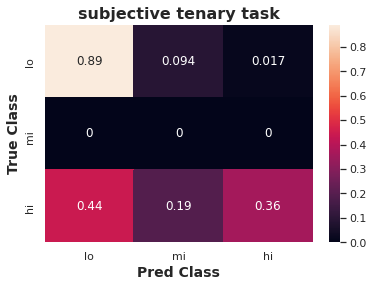

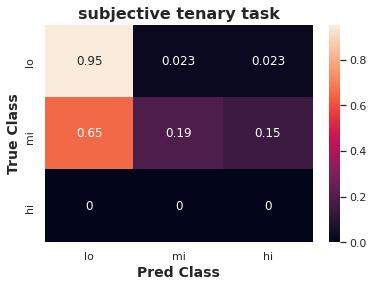

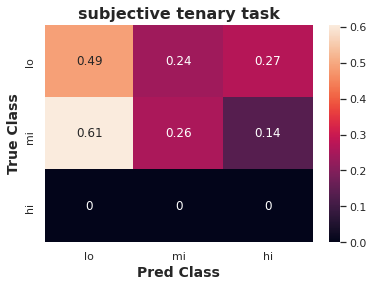

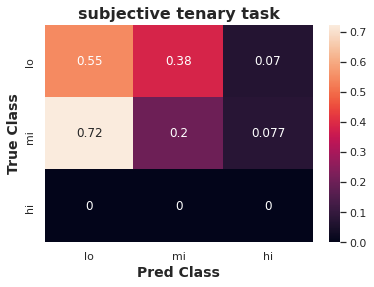

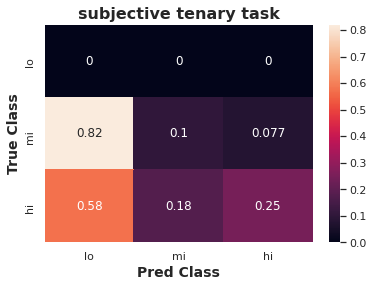

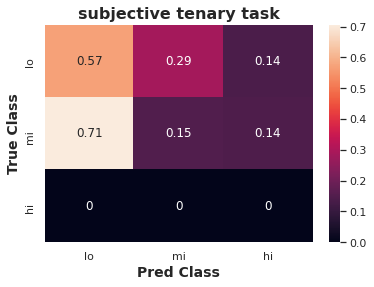

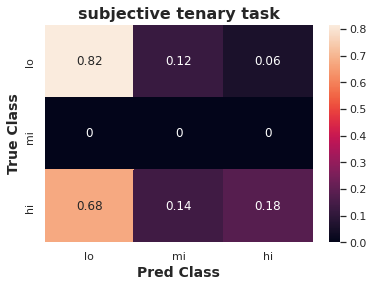

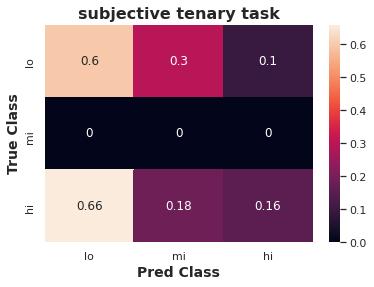

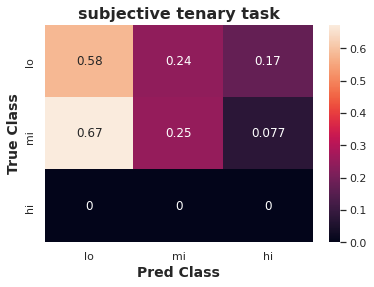

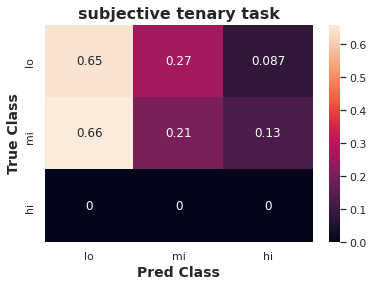

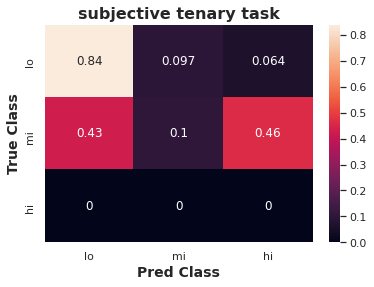

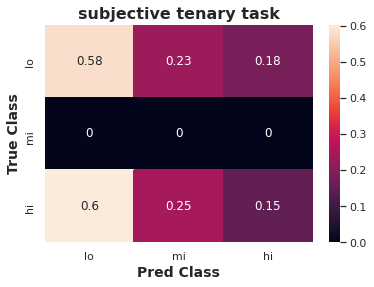

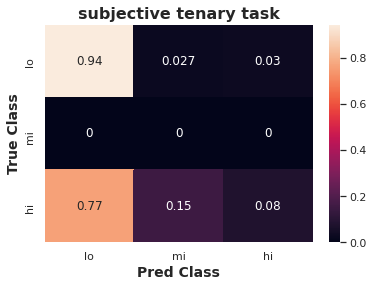

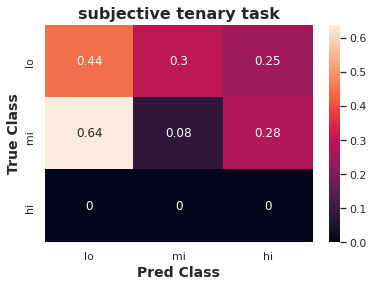

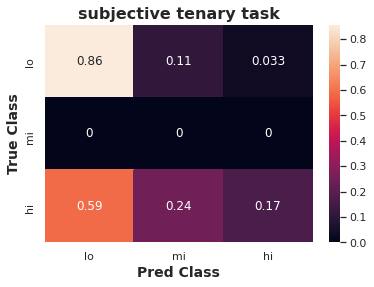

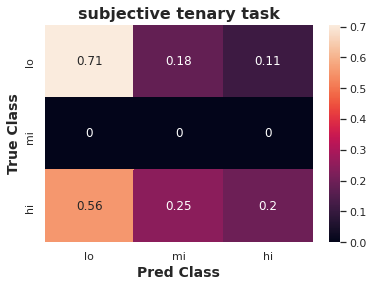

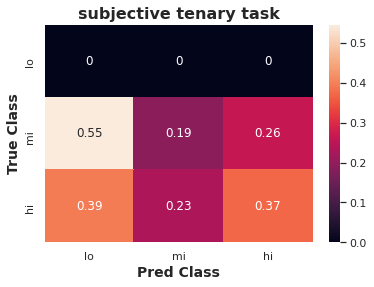

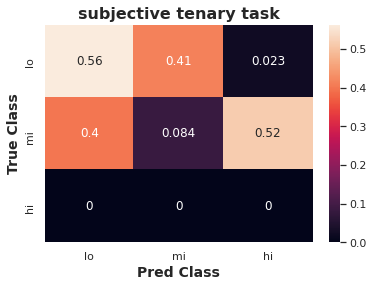

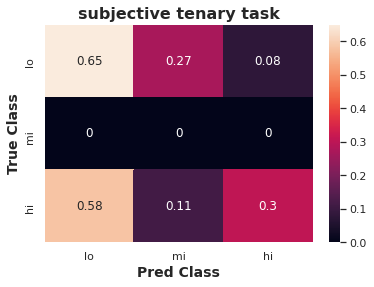

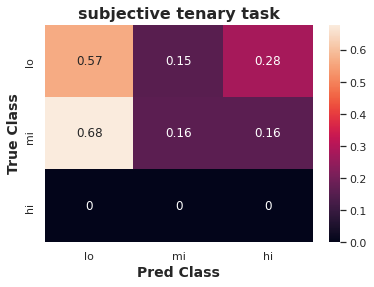

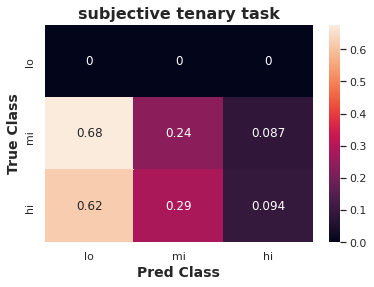

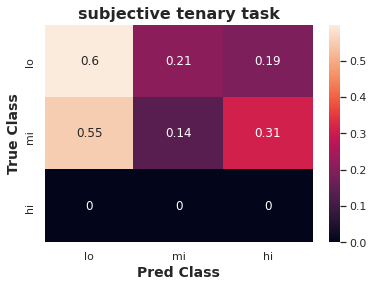

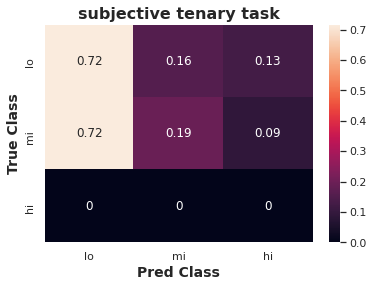

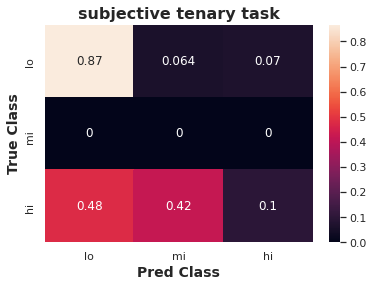

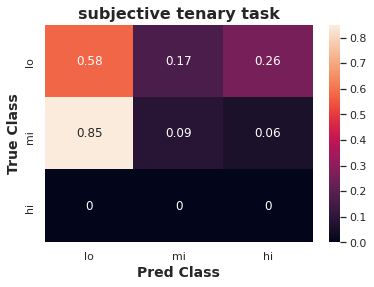

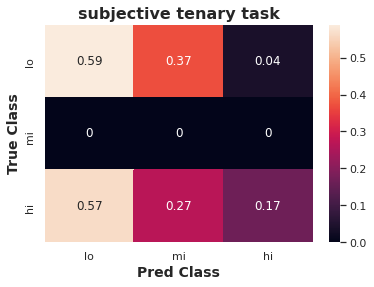

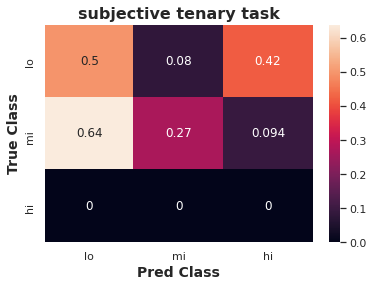

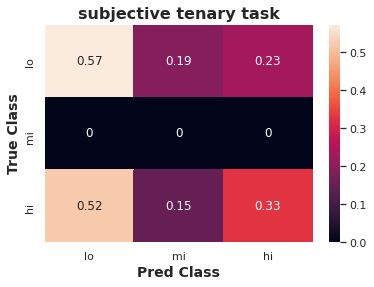

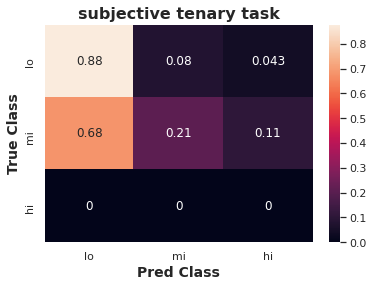

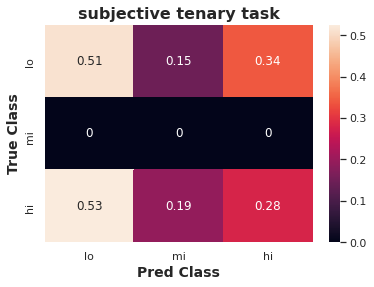

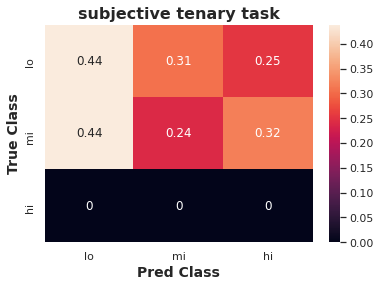

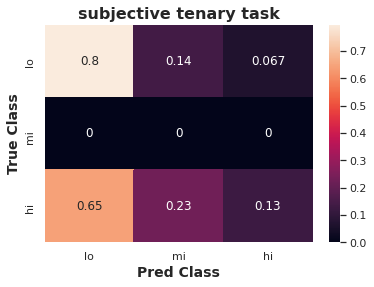

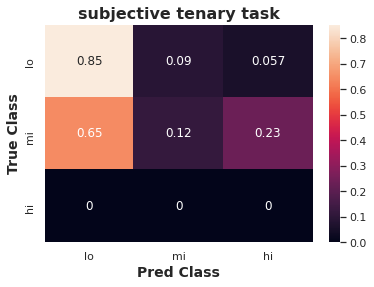

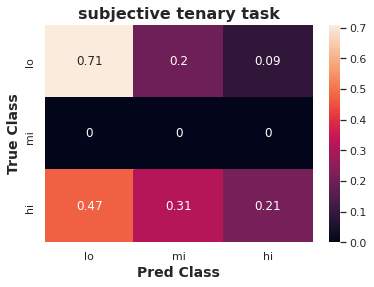

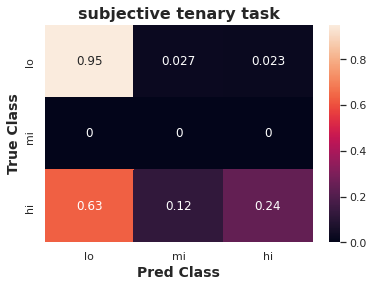

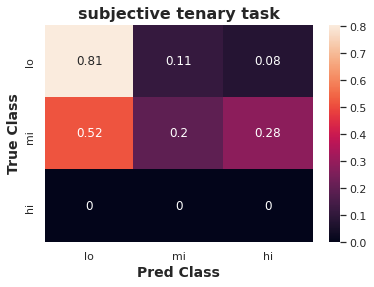

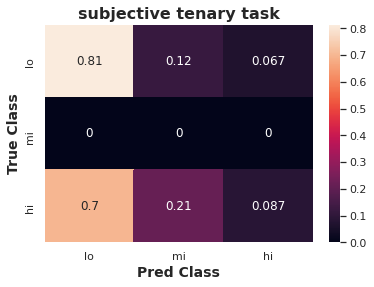

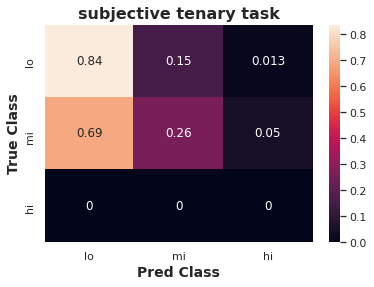

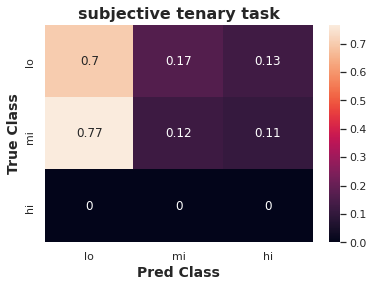

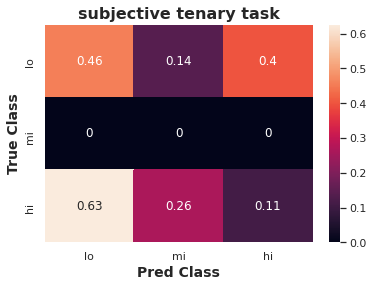

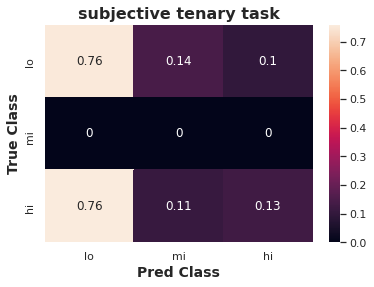

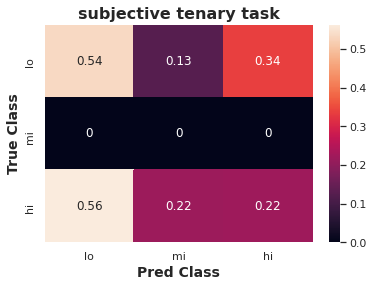

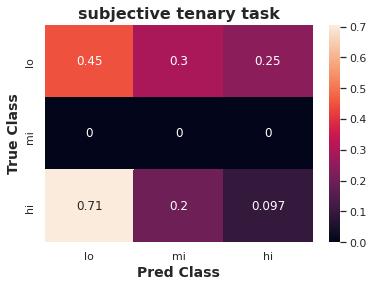

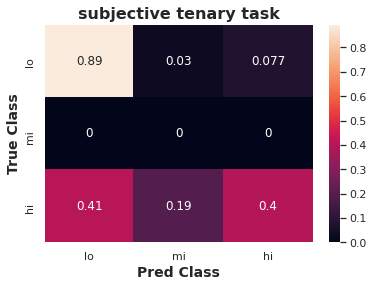

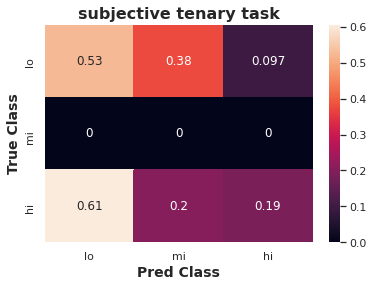

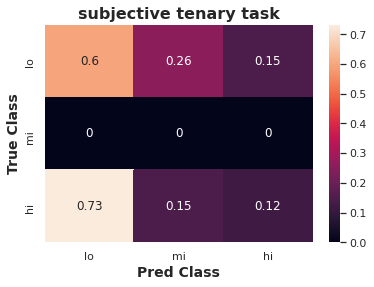

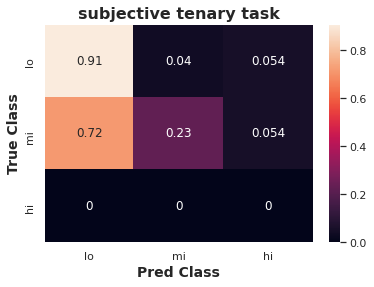

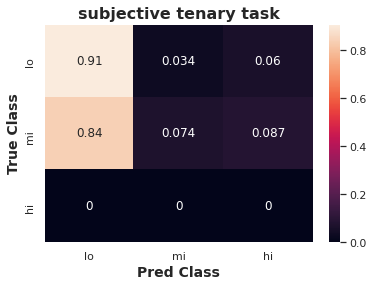

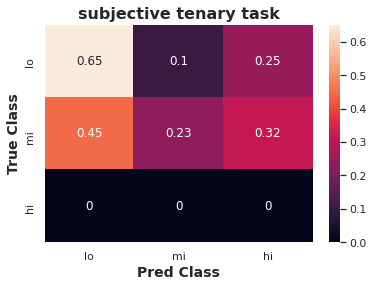

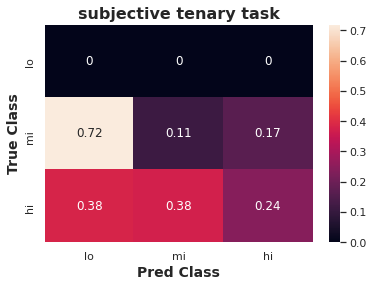

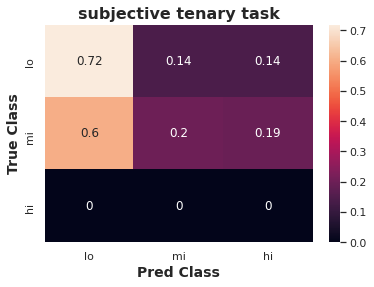

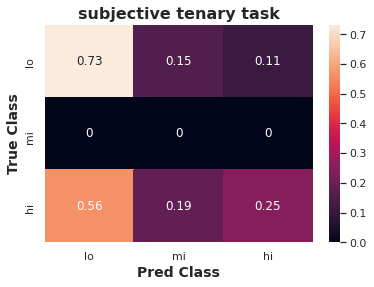

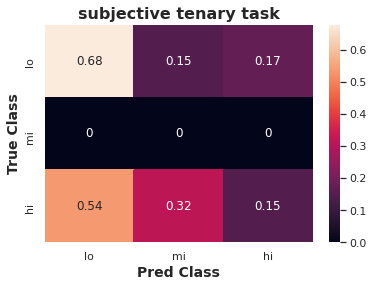

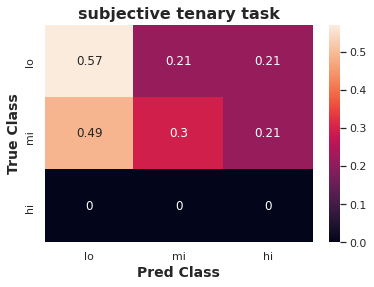

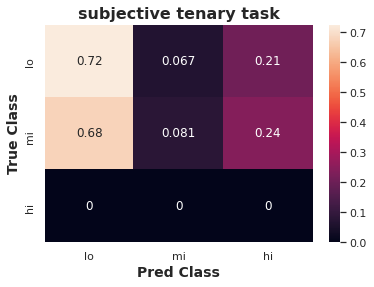

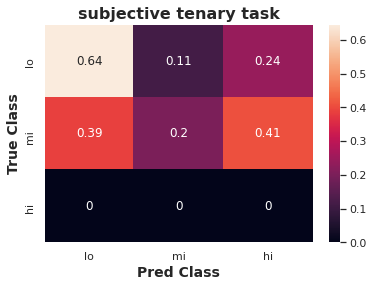

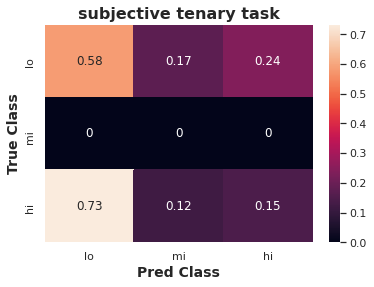

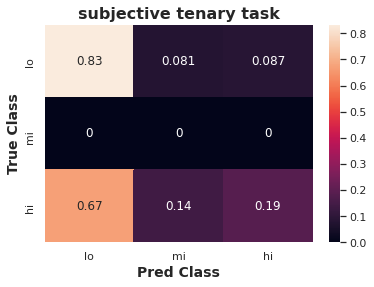

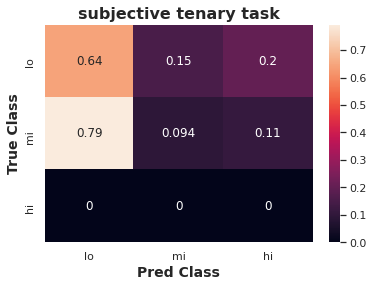

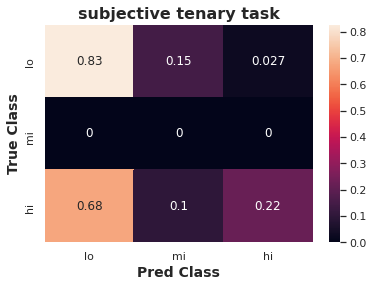

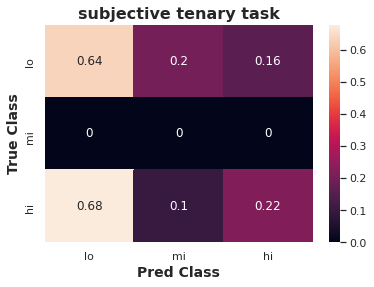

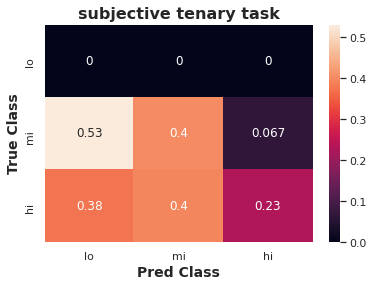

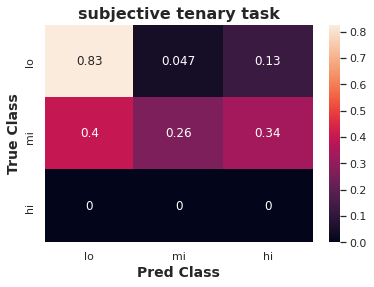

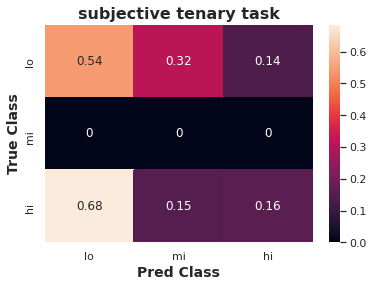

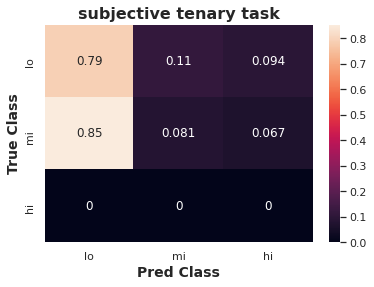

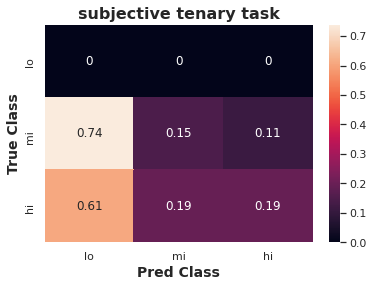

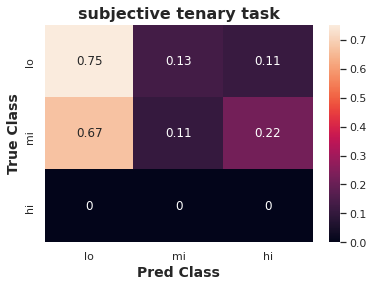

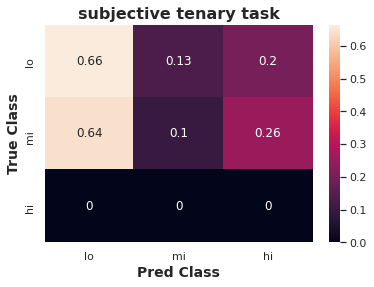

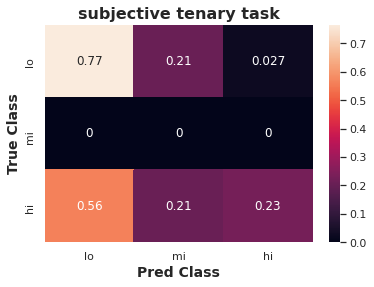

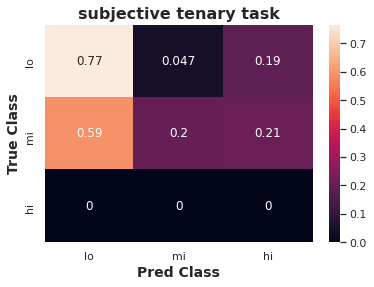

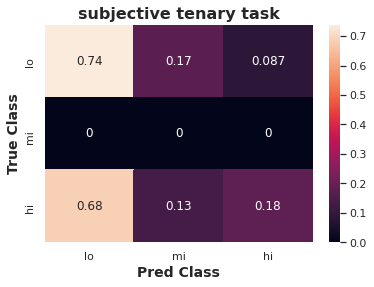

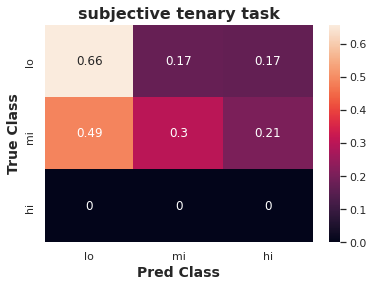

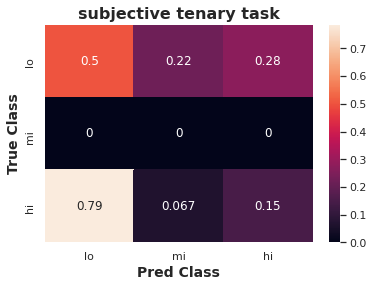

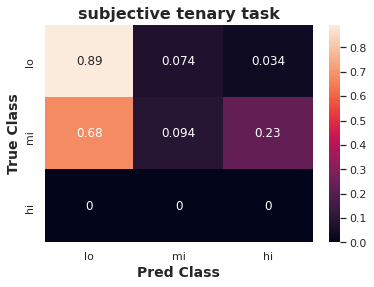

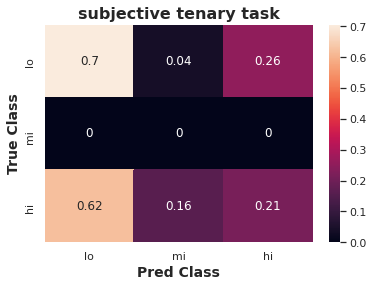

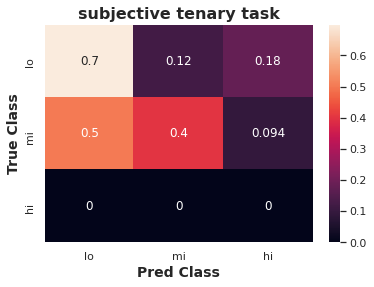

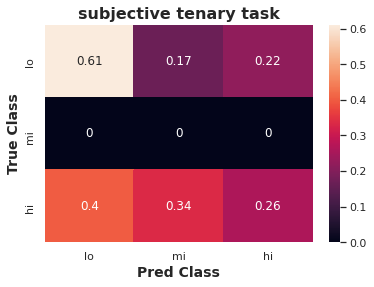

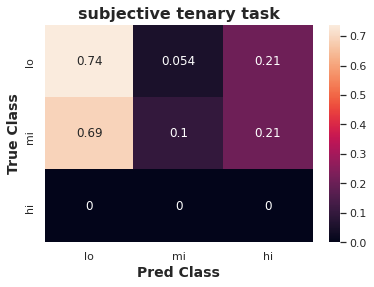

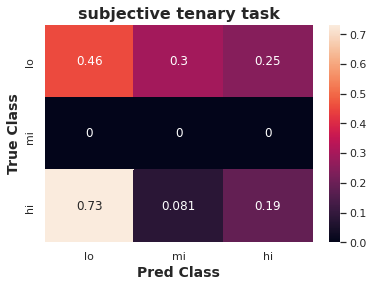

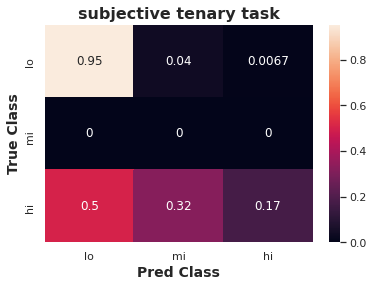

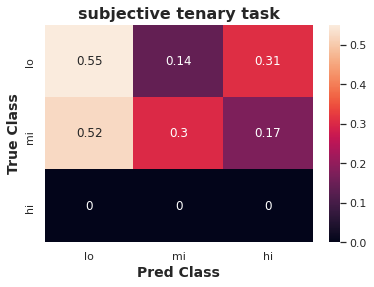

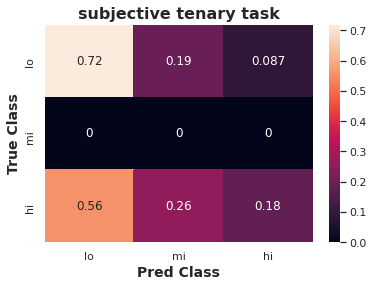

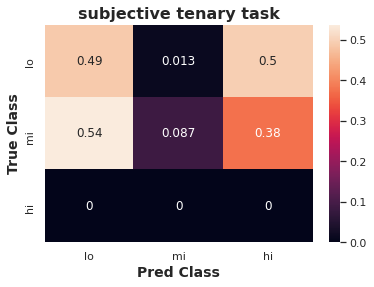

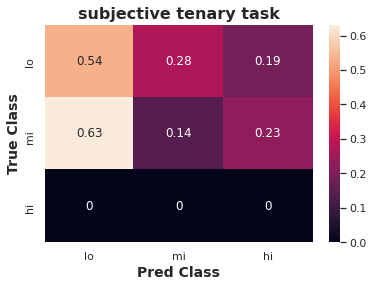

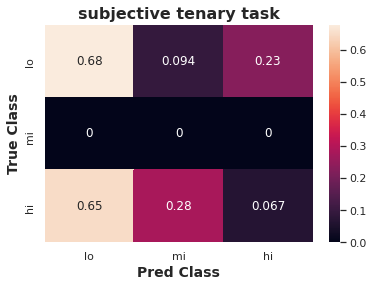

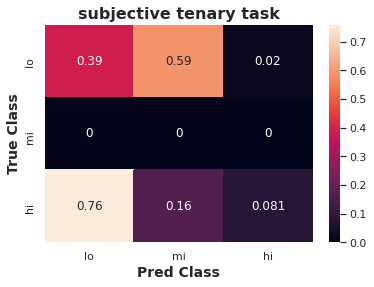

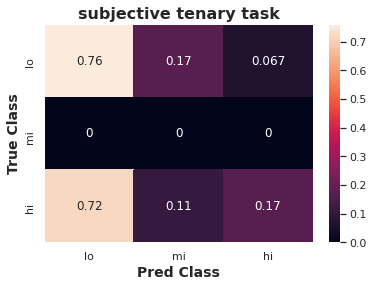

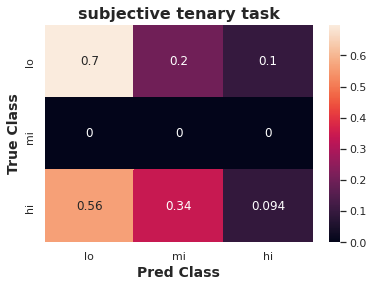

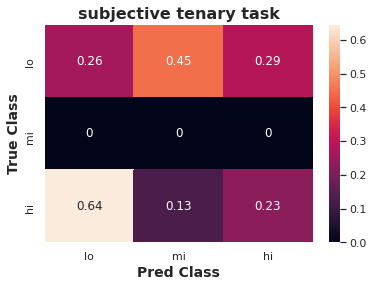

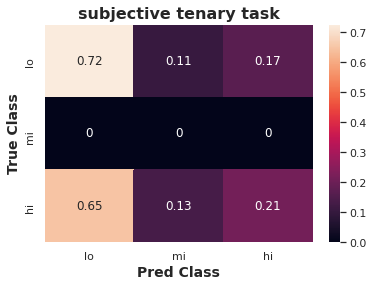

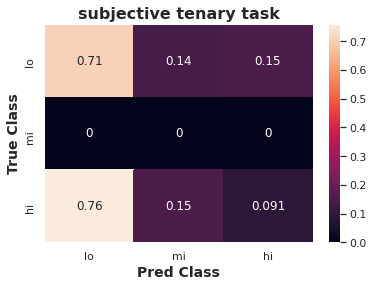

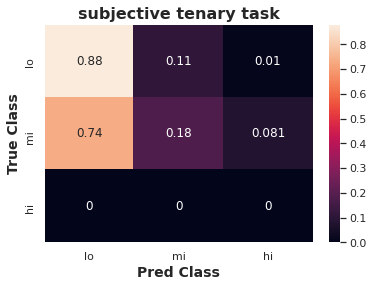

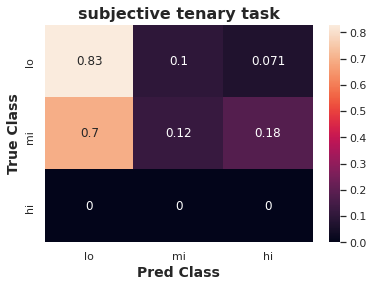

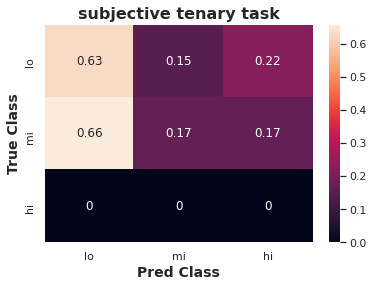

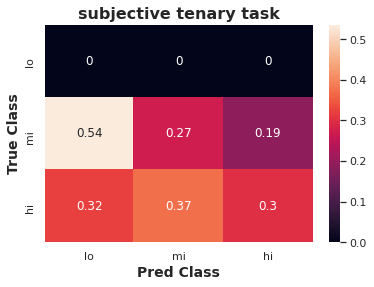

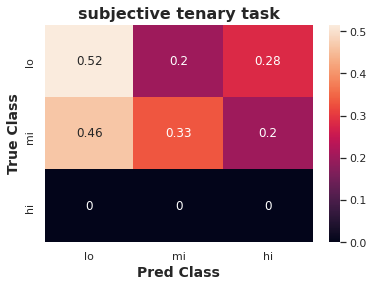

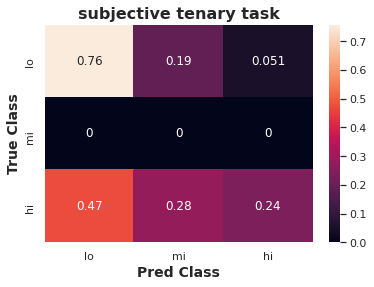

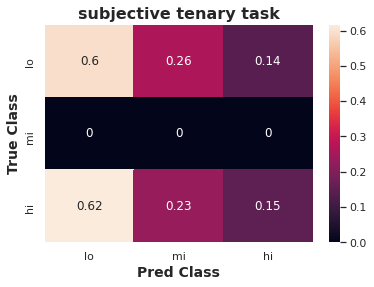

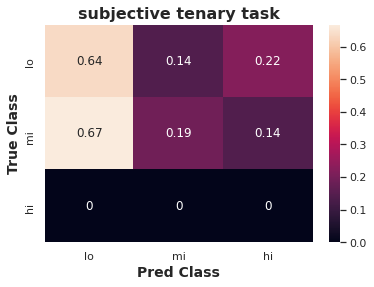

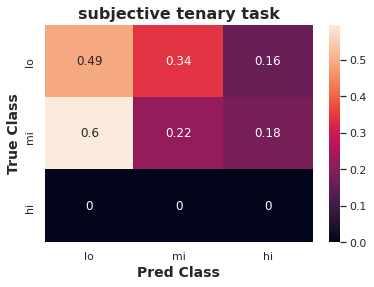

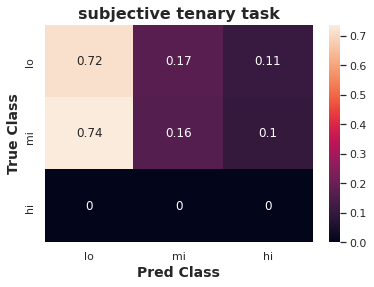

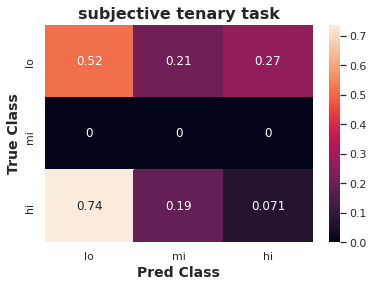

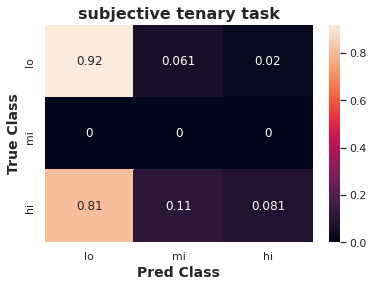

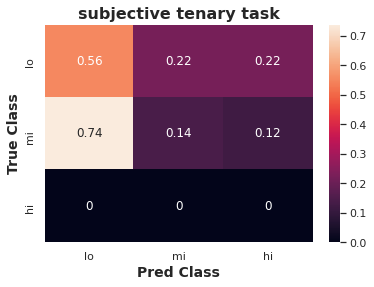

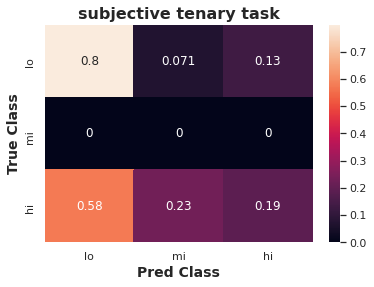

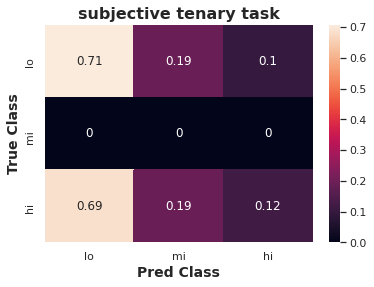

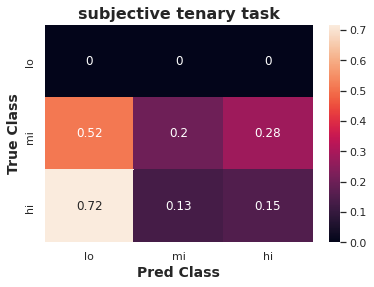

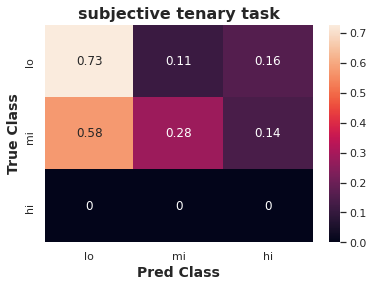

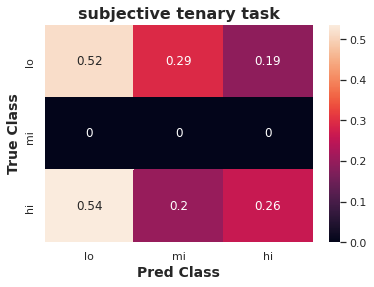

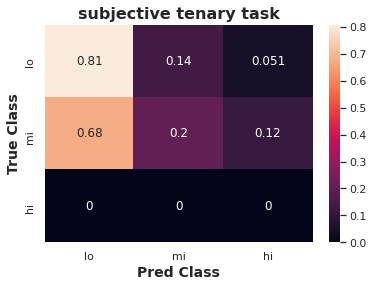

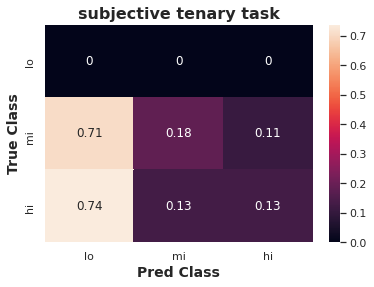

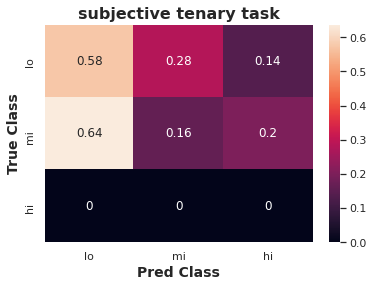

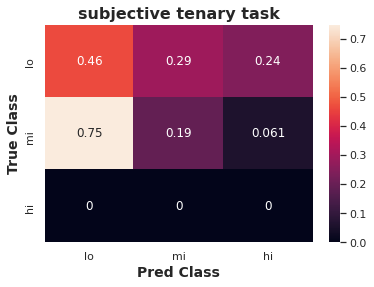

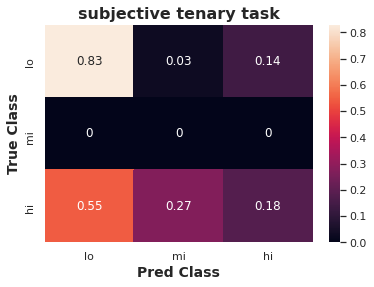

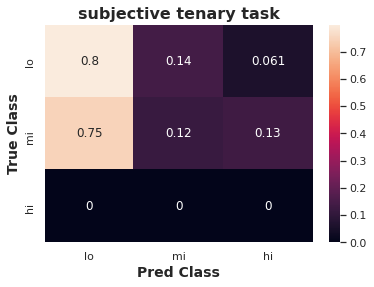

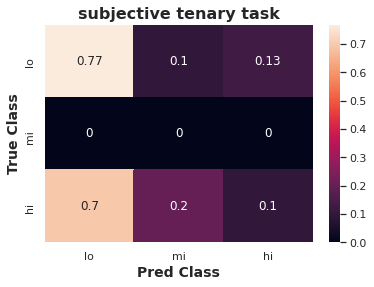

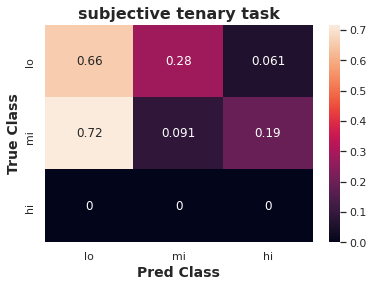

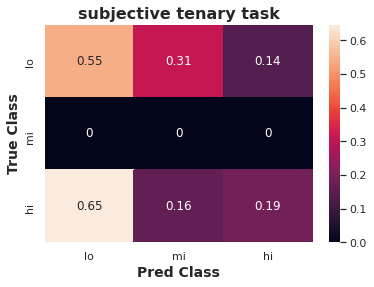

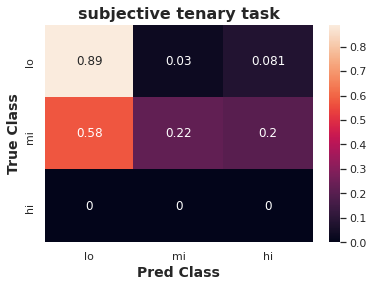

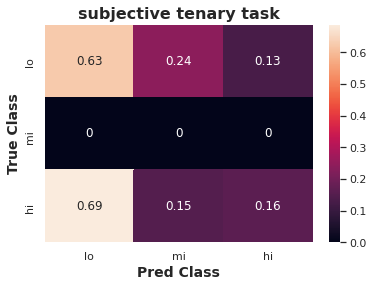

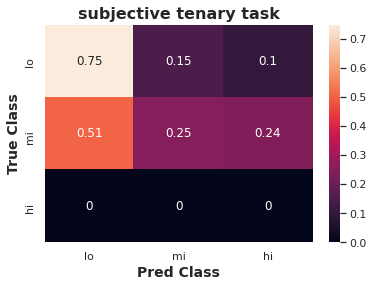

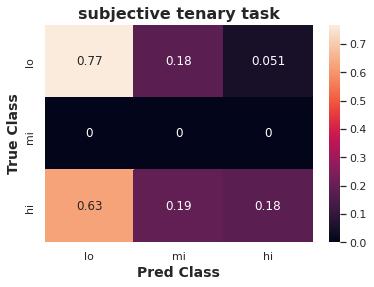

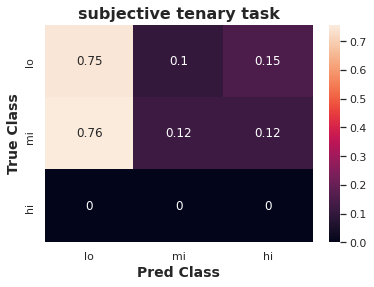

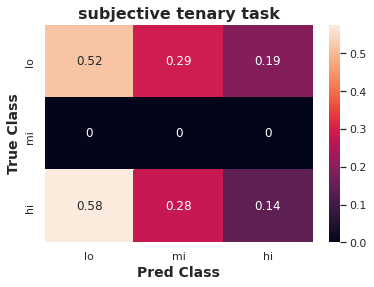

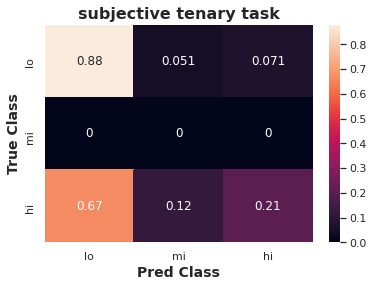

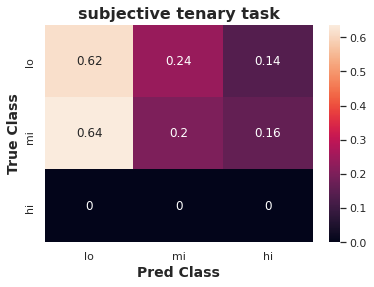

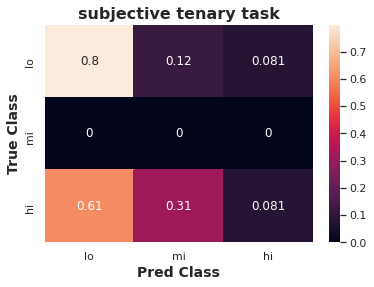

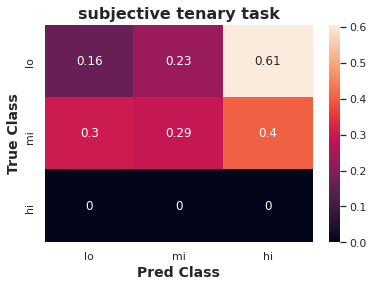

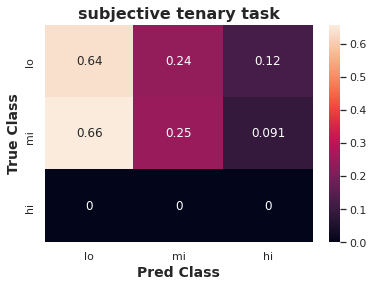

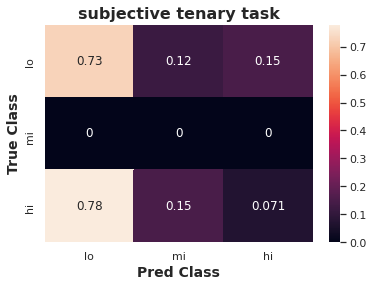

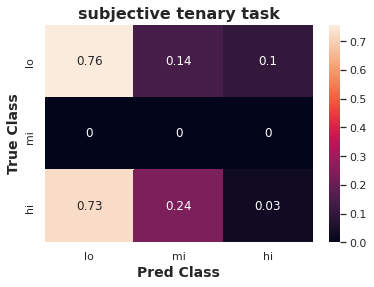

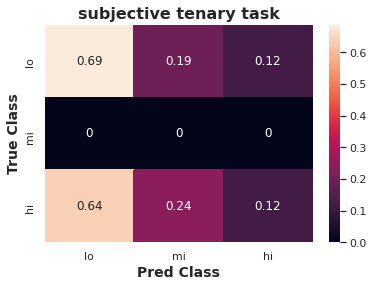

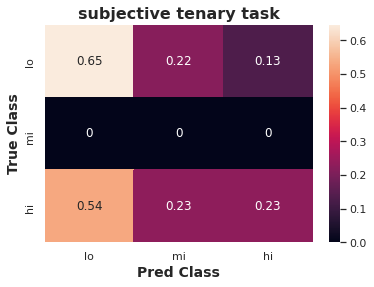

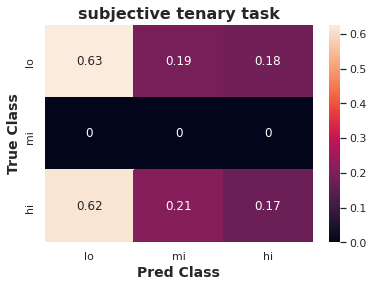

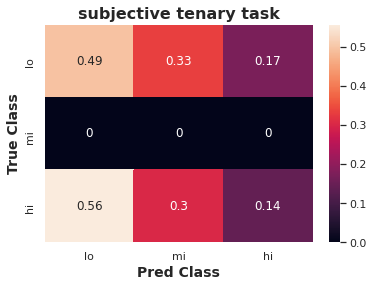

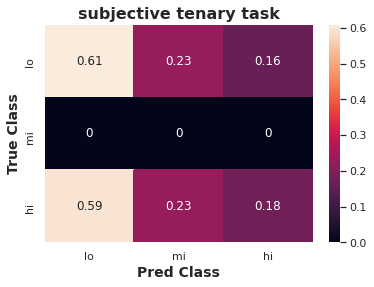

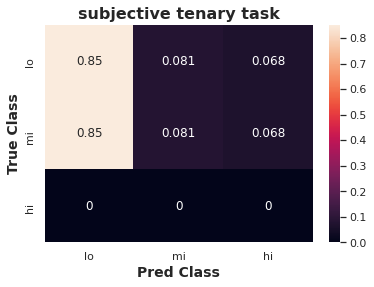

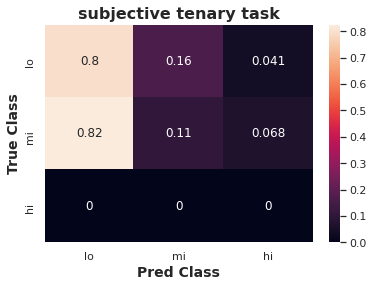

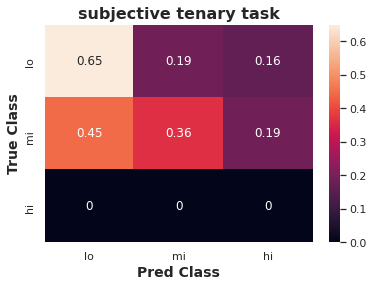

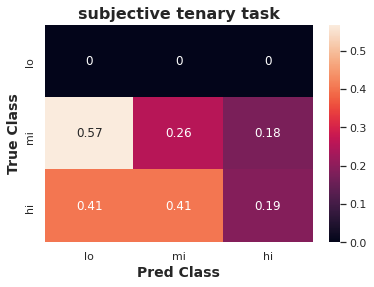

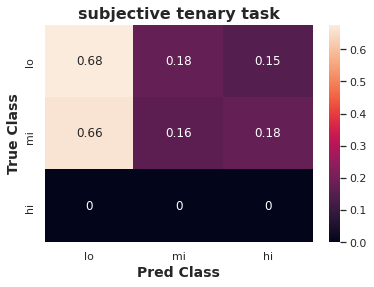

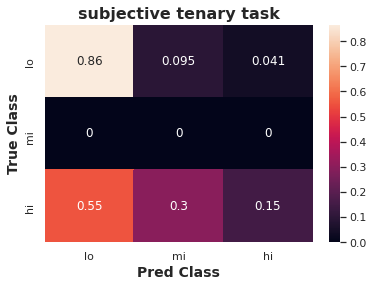

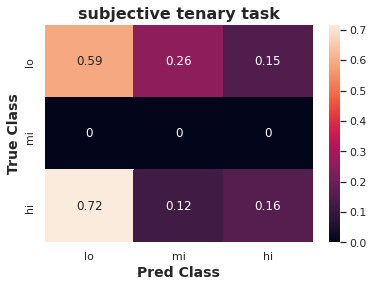

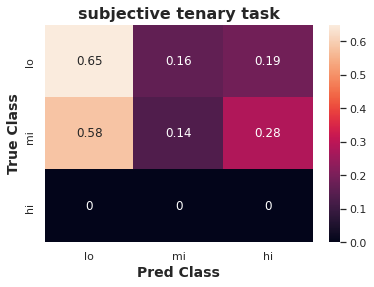

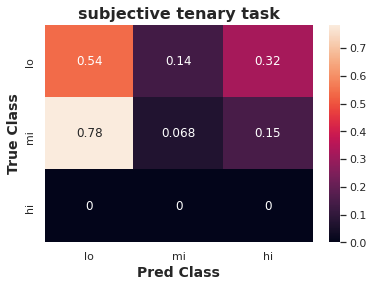

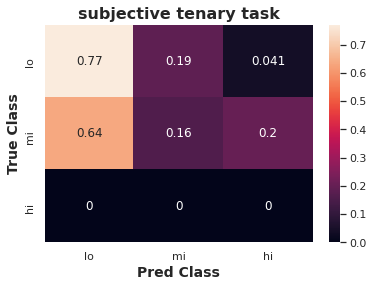

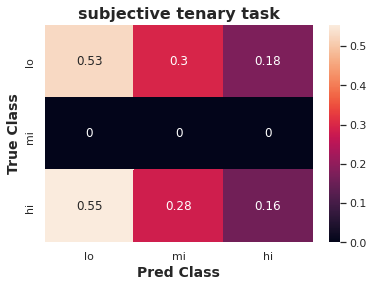

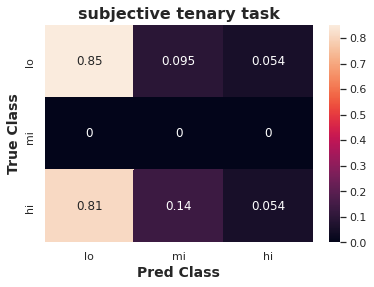

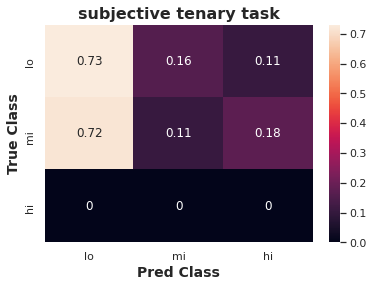

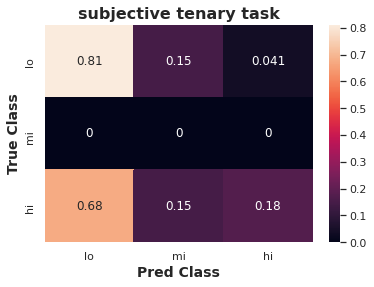

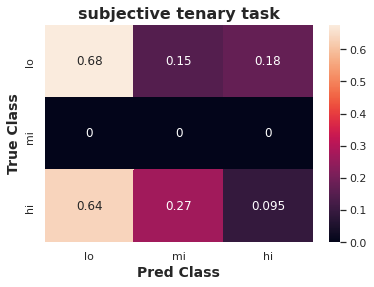

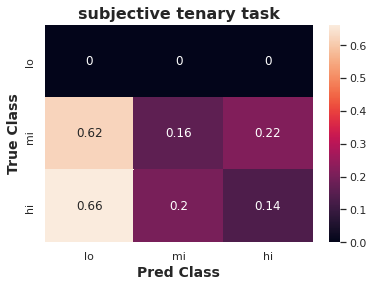

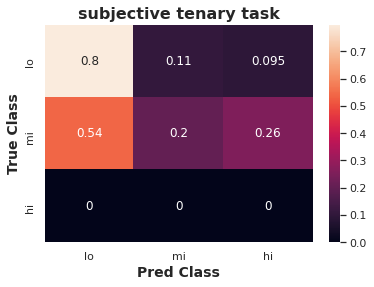

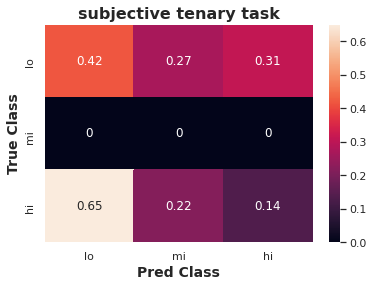

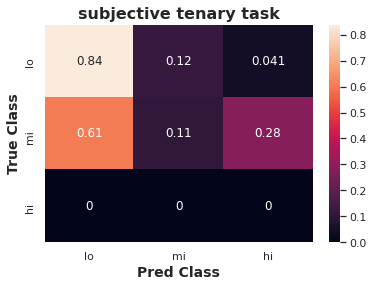

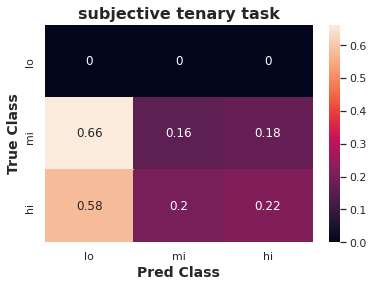

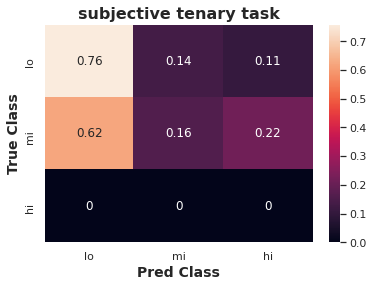

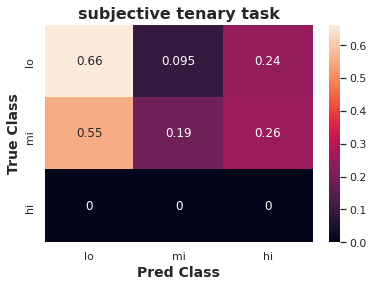

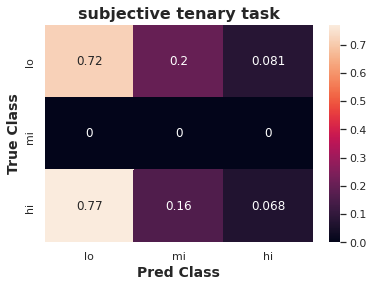

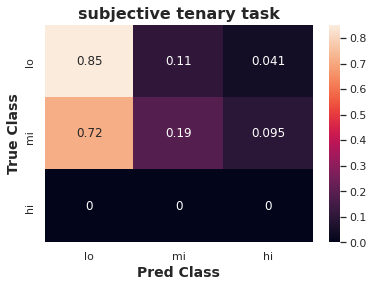

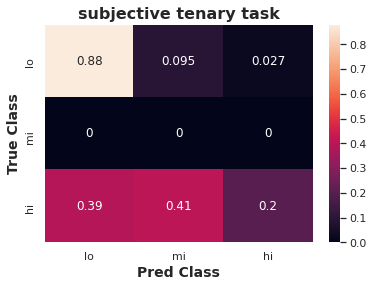

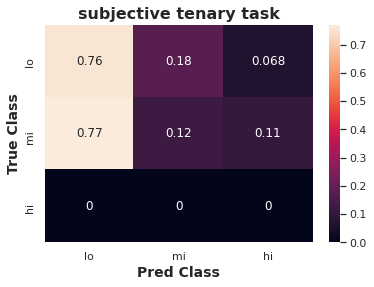

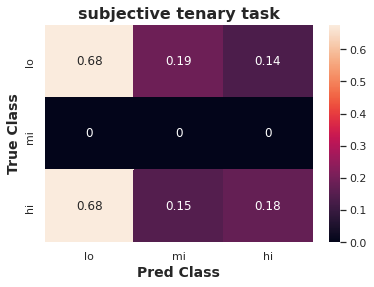

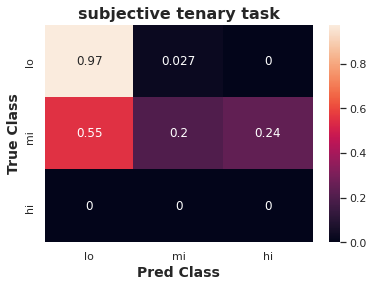

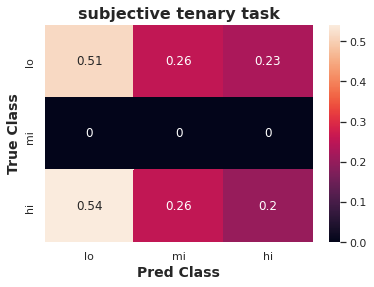

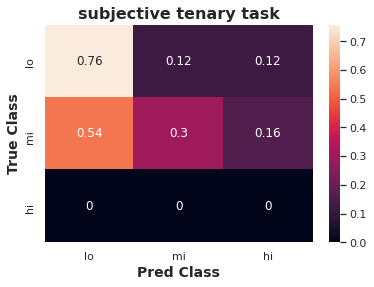

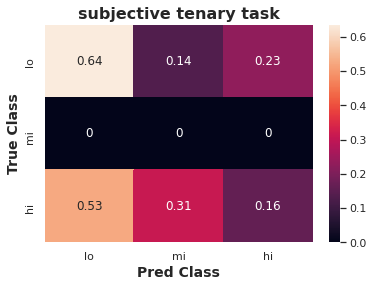

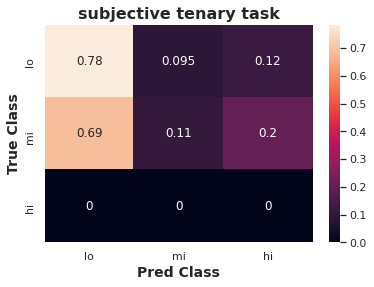

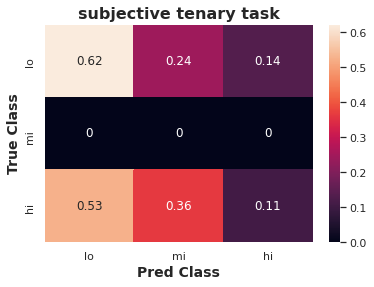

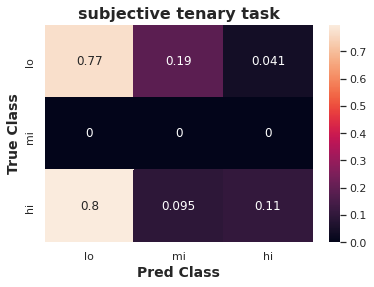

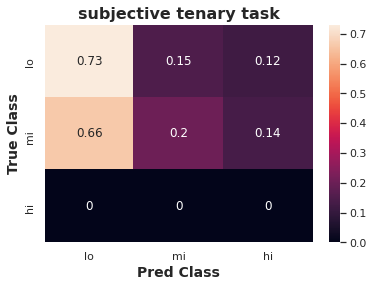

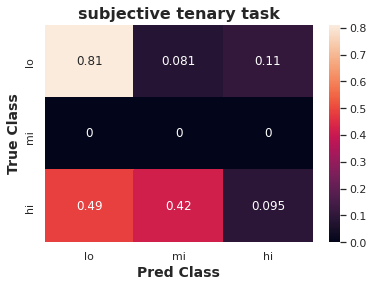

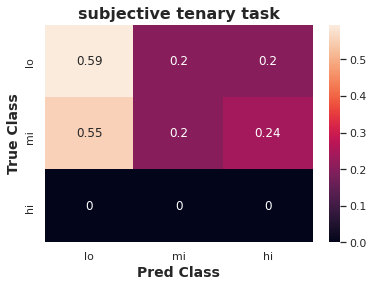

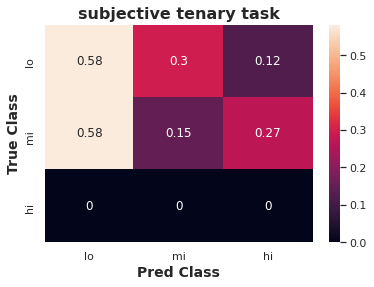

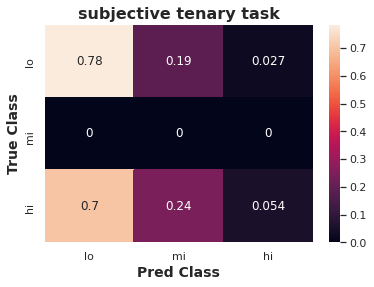

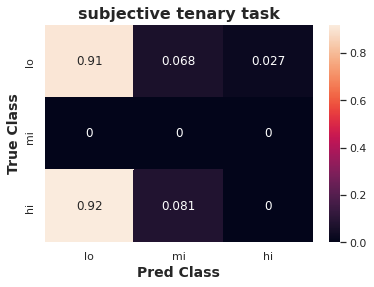

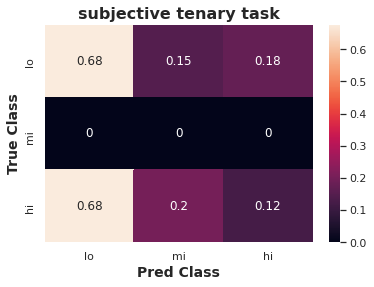

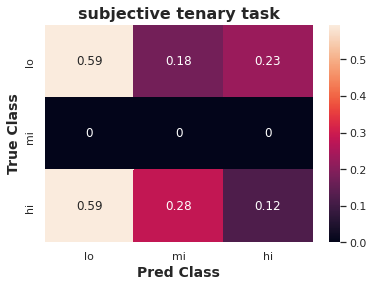

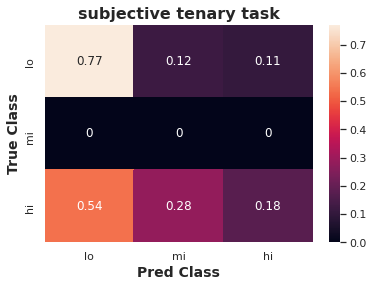

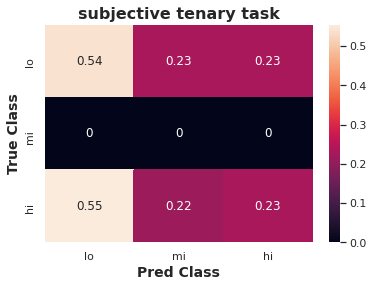

In [84]:
for sw in range(1, 5):
    update_sample(sliding_win=sw, overlap_win=sw/2)
    subjective_LOSO(sw)

#### intra-subject

In [23]:
def gen_intra_subject_sample():
    def get_sample(cls="test"):
        #print(f"cur sub is : {out_sub_id}", end=", ")
        dest_path = os.path.join(cur_path, "fea_pkl_dir/pkl_{}".format(cls))
        processor = Preprocessing(fs=128, src_path=source_path, dst_path=dest_path)
        print("cur rating id is {}".format(processor.rating_id), end=", ")
        all_file = os.listdir(dest_path)
        sample_last = np.zeros((0,200))
        label_last = np.zeros((0,1))
        for fname in all_file:
            sub_id = int(fname.split(".")[0].split("_")[1])
            if sub_id in [5, 24, 42]:
                continue
            with open(os.path.join(dest_path, fname), "rb") as pkl_file:
                sample_sub= pickle.load(pkl_file)
                label_sub = np.ones((len(sample_sub), 1), dtype=int) * processor.get_sub_label(sub_id)
                test_sample = sample_sub
                test_lable = label_sub
                # 为当前样本进行5折交叉
                n_samples = sample_sub.shape[0]
                groups = np.zeros(n_samples)
                groups[:int(n_samples/5)] = 1
                groups[int(n_samples/5):int(n_samples*2/5)] = 2
                groups[int(n_samples*2/5):int(n_samples*3/5)] = 3
                groups[int(n_samples*3/5):int(n_samples*4/5)] = 4
                groups[int(n_samples*4/5):] = 5 
                yield (test_sample, test_lable, sub_id, groups)

    for test_, rest_ in zip(get_sample("test"), get_sample("rest")):
        #test_ = test_[0], rest_[0]
        sample = np.concatenate((test_[0], rest_[0]), axis=0)
        label = np.concatenate((test_[1], rest_[1]), axis=0)
        groups = np.concatenate((test_[3], rest_[3]), axis=0)
        yield sample, label, test_[2], groups
                        
                        

In [25]:
for sw in range(1, 5):
    update_sample(sliding_win=sw, overlap_win=sw/2)
    for sample, label, sub_id, groups in gen_intra_subject_sample():
        clf = RF()
        #clf = LR()
        #clf = MLP()
        #clf = KNN()
        start = time()
        Kfold_validation(clf, sample, label, groups, sw=sw, task="tenary", sub=sub_id, path="RF/intra_subject", pw_level=0, show_cm=0, repeats=1)
        end = time()
        print(f"{sub_id}: {end-start}s")
        #break

滑动窗口1s, 重叠时间0.5s
current extracting feature for hi.txt and rating id is 2
extracting sub29, extracting sub42, extracting sub23, extracting sub6, extracting sub40, extracting sub43, extracting sub38, extracting sub10, extracting sub27, extracting sub21, extracting sub34, extracting sub41, extracting sub13, extracting sub7, extracting sub47, extracting sub39, extracting sub36, extracting sub33, extracting sub32, extracting sub8, extracting sub35, extracting sub30, extracting sub14, extracting sub5, extracting sub9, extracting sub24, extracting sub4, extracting sub17, extracting sub25, extracting sub3, extracting sub44, extracting sub18, extracting sub31, extracting sub26, extracting sub12, extracting sub2, extracting sub16, extracting sub20, extracting sub37, extracting sub19, extracting sub28, extracting sub46, extracting sub15, extracting sub1, extracting sub48, extracting sub45, extracting sub22, extracting sub11, 

滑动窗口1s, 重叠时间0.5s
current extracting feature for lo.txt and rating id 